# Generative Modeling: Autoencoders and Variational Autoencoders (VAEs)

Autoencoders and Variational Autoencoders (VAEs) are neural network architectures widely used in generative modeling tasks, including image generation, data compression, and feature learning. These models are designed to learn and generate data by capturing meaningful representations of the input.

## Autoencoder

An autoencoder is a type of neural network with two main components: an encoder and a decoder. Its primary goal is to learn a compressed representation (latent space) of the input data while maintaining the ability to reconstruct the input.

- **Encoder**: Maps the input data to a lower-dimensional representation (latent space).  
- **Decoder**: Reconstructs the input from the encoded representation.  
- **Training Objective**: The training process minimizes reconstruction error, often using loss functions like mean squared error (MSE). This enables the network to identify essential features and patterns, effectively compressing the data into its latent space.

Once trained, the decoder can generate data by sampling from the latent space, making autoencoders useful for representation learning and data reconstruction.

## Variational Autoencoder (VAE)

A VAE extends the autoencoder by introducing probabilistic concepts, making it more suitable for generative modeling tasks. It learns not only a latent representation but also the uncertainty associated with it.

- **Encoder**: Maps input data to a probability distribution in the latent space, typically outputting the mean and variance of a multivariate Gaussian distribution.  
- **Decoder**: Generates data points from a sample drawn from the latent space.  

### Training Objectives:
1. **Reconstruction Loss**: Similar to autoencoders, it measures how well the input is reconstructed.  
2. **Regularization Loss (KL Divergence)**: Ensures the distribution in the latent space matches a standard Gaussian distribution.

The combined losses encourage the VAE to learn a structured and smooth latent space, making it easier to generate novel data points by sampling from the learned distribution.

### Key Difference:
- Autoencoders produce a deterministic latent representation for reconstruction.  
- VAEs learn a probabilistic latent space, enabling them to generate new data samples and capture data uncertainty effectively.

## Modern Autoencoders

Autoencoders have evolved significantly from their traditional applications in dimensionality reduction and feature learning. Modern autoencoders generalize the encoding and decoding processes using stochastic mappings, such as \( p_{\text{encoder}}(h | x) \) and \( p_{\text{decoder}}(x | h) \). This connection to latent variable models has elevated autoencoders as a cornerstone in generative modeling.

### Characteristics:
- Autoencoders are trained to approximate \( g(f(x)) \approx x \), focusing only on aspects of the input that resemble the training data.  
- This constraint helps the model prioritize useful properties of the data, making it highly effective for feature extraction.

Training is typically performed using techniques like minibatch gradient descent and backpropagation.

## Examples and Applications

In this tutorial, we will explore autoencoders and VAEs through the following steps:
1. **Autoencoders**:
   - Basic autoencoder concepts.
   - Image denoising.
   - Anomaly detection.
2. **Variational Autoencoder (VAE)**:
   - Introduction to VAEs.
   - Practical implementation of VAEs for generative modeling.

By the end, you will gain an understanding of how autoencoders and VAEs can be applied to various tasks, from data reconstruction to generating novel data samples.

_Source: [deeplearningbook.org](http://deeplearningbook.org)_


In [1]:
!pip install torch torchvision

In [2]:
# Import PyTorch and other necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [3]:
# Load the FashionMNIST dataset
transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Normalize the data to [0,1]
x_train = train_dataset.data.float() / 255.0
x_test = test_dataset.data.float() / 255.0

print(x_train.shape)  # torch.Size([60000, 28, 28])
print(x_test.shape)   # torch.Size([10000, 28, 28])

100%|██████████| 26421880/26421880 [00:01<00:00, 21749930.17it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 326787.33it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6051213.19it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14472035.52it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


Define an autoencoder with two Dense layers: an encoder, which compresses the images into a 64 dimensional latent vector, and a decoder, that reconstructs the original image from the latent space.

To define your model, use the Keras Model Subclassing API.

In [4]:
# Define the Autoencoder model
latent_dim = 64

class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, latent_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)


In [5]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)


Train the model using x_train as both the input and the target. The encoder will learn to compress the dataset from 784 dimensions to the latent space, and the decoder will learn to reconstruct the original images.

In [6]:
# Prepare DataLoader
train_loader = DataLoader(TensorDataset(x_train), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test), batch_size=128, shuffle=False)

# Training loop
num_epochs = 10
autoencoder.train()
for epoch in range(num_epochs):
    train_loss = 0
    for data in train_loader:
        inputs = data[0].unsqueeze(1)  # Add channel dimension
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    
    # Validation loss
    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        for data in test_loader:
            inputs = data[0].unsqueeze(1)
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(test_loader.dataset)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    autoencoder.train()


Epoch [1/10], Train Loss: 0.0417, Val Loss: 0.0242
Epoch [2/10], Train Loss: 0.0202, Val Loss: 0.0171
Epoch [3/10], Train Loss: 0.0155, Val Loss: 0.0143
Epoch [4/10], Train Loss: 0.0136, Val Loss: 0.0130
Epoch [5/10], Train Loss: 0.0126, Val Loss: 0.0122
Epoch [6/10], Train Loss: 0.0119, Val Loss: 0.0117
Epoch [7/10], Train Loss: 0.0115, Val Loss: 0.0114
Epoch [8/10], Train Loss: 0.0112, Val Loss: 0.0112
Epoch [9/10], Train Loss: 0.0110, Val Loss: 0.0110
Epoch [10/10], Train Loss: 0.0109, Val Loss: 0.0109


In [7]:
# Encode and decode test images
autoencoder.eval()
with torch.no_grad():
    test_images = x_test.unsqueeze(1)  # Add channel dimension
    encoded_imgs = autoencoder.encoder(test_images).numpy()
    decoded_imgs = autoencoder.decoder(torch.tensor(encoded_imgs)).numpy()

Now that the model is trained, let's test it by encoding and decoding images from the test set.

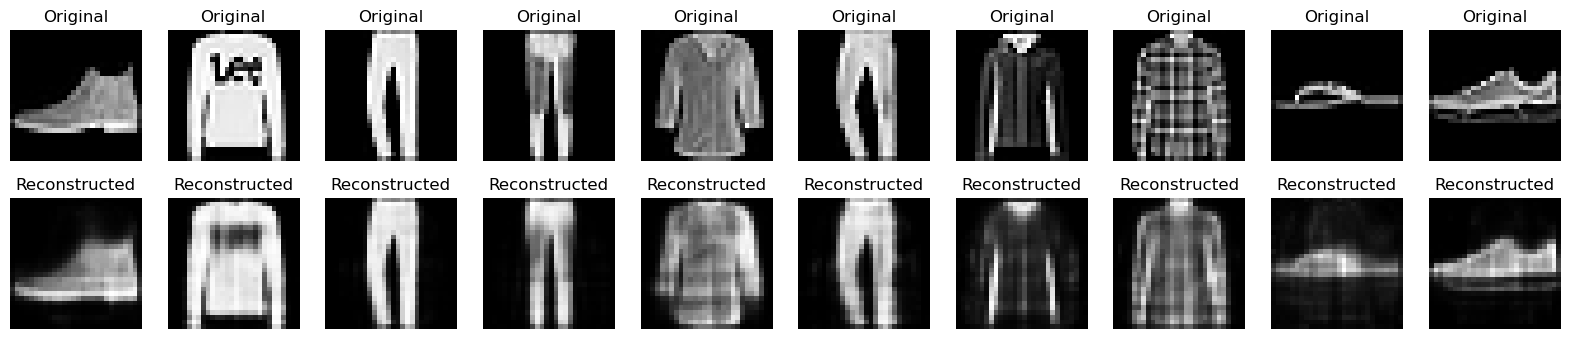

In [8]:
# Visualize original and reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

## Second example: Image denoising
An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [9]:
# Reload the FashionMNIST dataset (if needed)
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [10]:
# Normalize and add channel dimension
x_train = train_dataset.data.float() / 255.0
x_test = test_dataset.data.float() / 255.0

x_train = x_train.unsqueeze(-1)  # Shape: [60000, 28, 28, 1]
x_test = x_test.unsqueeze(-1)    # Shape: [10000, 28, 28, 1]

print(x_train.shape)  # torch.Size([60000, 28, 28, 1])

torch.Size([60000, 28, 28, 1])


In [11]:
# Add Gaussian noise to the data
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * torch.randn_like(x_train)
x_test_noisy = x_test + noise_factor * torch.randn_like(x_test)

# Clip the values to be between 0 and 1
x_train_noisy = torch.clamp(x_train_noisy, 0., 1.)
x_test_noisy = torch.clamp(x_test_noisy, 0., 1.)

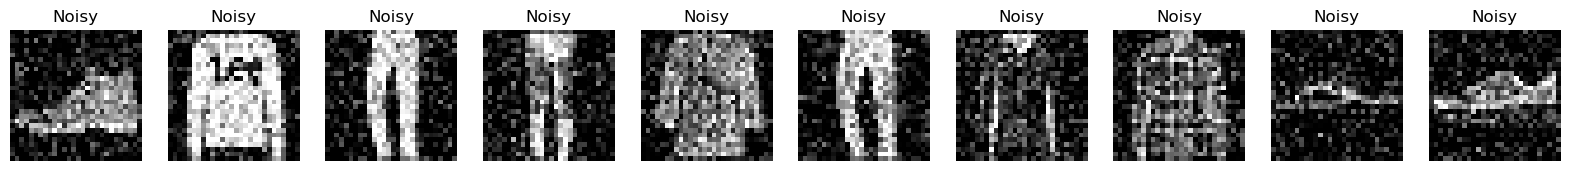

In [12]:
# Visualize noisy test images
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')
plt.show()

Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using Conv2D layers in the encoder, and Conv2DTranspose layers in the decoder.

In [13]:
# Define the Denoising Autoencoder model using convolutional layers
class Denoise(nn.Module):
    def __init__(self):
        super(Denoise, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # Output: [16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),  # Output: [8, 7, 7]
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1, output_padding=1),  # [8, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # [16, 28, 28]
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),  # [1, 28, 28]
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

In [14]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [15]:
# Prepare DataLoader for noisy and clean data
train_noisy = x_train_noisy.permute(0, 3, 1, 2)  # Shape: [60000, 1, 28, 28]
train_clean = x_train.permute(0, 3, 1, 2)        # Shape: [60000, 1, 28, 28]
test_noisy = x_test_noisy.permute(0, 3, 1, 2)    # Shape: [10000, 1, 28, 28]
test_clean = x_test.permute(0, 3, 1, 2)          # Shape: [10000, 1, 28, 28]

train_dataset_dn = TensorDataset(train_noisy, train_clean)
test_dataset_dn = TensorDataset(test_noisy, test_clean)

train_loader_dn = DataLoader(train_dataset_dn, batch_size=128, shuffle=True)
test_loader_dn = DataLoader(test_dataset_dn, batch_size=128, shuffle=False)

# Training loop
num_epochs = 10
autoencoder.train()
for epoch in range(num_epochs):
    train_loss = 0
    for noisy, clean in train_loader_dn:
        optimizer.zero_grad()
        outputs = autoencoder(noisy)
        loss = criterion(outputs, clean)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * noisy.size(0)
    train_loss /= len(train_loader_dn.dataset)
    
    # Validation loss
    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        for noisy, clean in test_loader_dn:
            outputs = autoencoder(noisy)
            loss = criterion(outputs, clean)
            val_loss += loss.item() * noisy.size(0)
    val_loss /= len(test_loader_dn.dataset)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    autoencoder.train()

Epoch [1/10], Train Loss: 0.0382, Val Loss: 0.0135
Epoch [2/10], Train Loss: 0.0121, Val Loss: 0.0112
Epoch [3/10], Train Loss: 0.0107, Val Loss: 0.0104
Epoch [4/10], Train Loss: 0.0100, Val Loss: 0.0099
Epoch [5/10], Train Loss: 0.0096, Val Loss: 0.0096
Epoch [6/10], Train Loss: 0.0094, Val Loss: 0.0093
Epoch [7/10], Train Loss: 0.0092, Val Loss: 0.0092
Epoch [8/10], Train Loss: 0.0090, Val Loss: 0.0089
Epoch [9/10], Train Loss: 0.0088, Val Loss: 0.0087
Epoch [10/10], Train Loss: 0.0086, Val Loss: 0.0085


In [16]:
!pip install torchsummary

In [17]:
# Display the encoder architecture summary
from torchsummary import summary

summary(autoencoder.encoder.to(device), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
              ReLU-2           [-1, 16, 14, 14]               0
            Conv2d-3              [-1, 8, 7, 7]           1,160
              ReLU-4              [-1, 8, 7, 7]               0
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.01
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


Plotting both the noisy images and the denoised images produced by the autoencoder.

In [18]:
# Encode and decode test images using the denoising autoencoder
autoencoder.eval()
with torch.no_grad():
    test_noisy_images = test_noisy  # [10000, 1, 28, 28]
    encoded_imgs = autoencoder.encoder(test_noisy_images.cuda()).cpu().numpy()
    decoded_imgs = autoencoder.decoder(torch.tensor(encoded_imgs)).cpu().numpy()

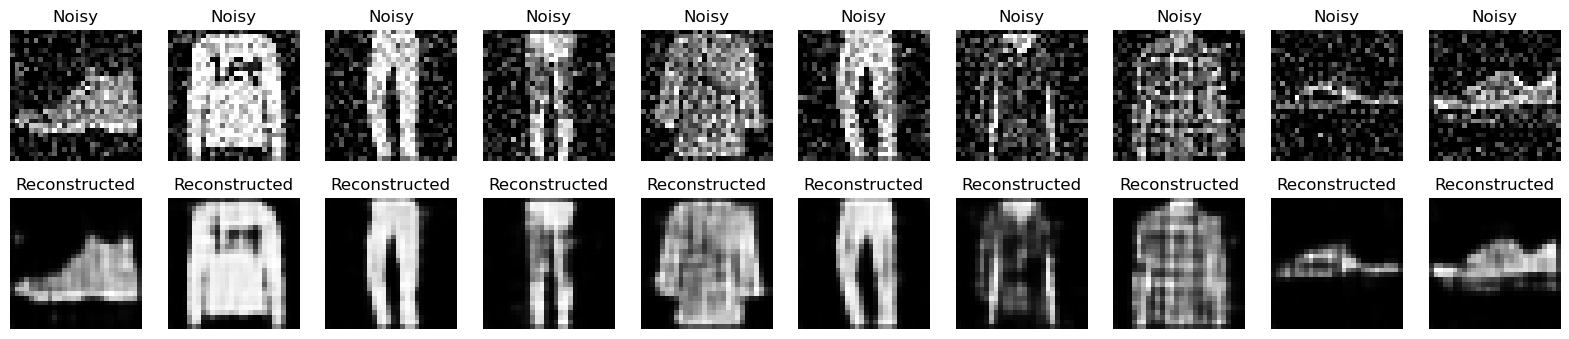

In [19]:
# Visualize noisy and reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Noisy images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')
    
    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

## Third example: Anomaly detection
### Overview

In this example, you will train an autoencoder to detect anomalies on the ECG5000 dataset. This dataset contains 5,000 Electrocardiograms, each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

Load ECG data

The dataset you will use is based on one from timeseriesclassification.com.


In [20]:
# Download and load the ECG dataset
url = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
dataframe = pd.read_csv(url, header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [21]:
# Separate labels and features
labels = raw_data[:, -1].astype(bool)  # Last column as labels
data = raw_data[:, :-1]                # All other columns as features

# Split into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [22]:
# Normalize the data to [0,1]
train_data = torch.tensor(train_data, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)

min_val = torch.min(train_data)
max_val = torch.max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)


You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as 1. Separate the normal rhythms from the abnormal rhythms.

In [23]:
# Separate normal and anomalous data based on labels
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

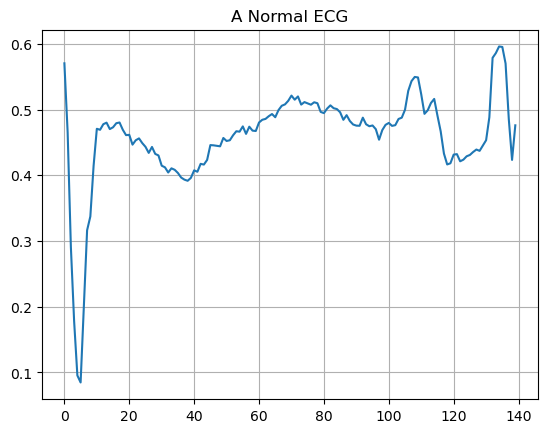

In [24]:
# Plot a normal ECG signal
plt.figure()
plt.grid()
plt.plot(normal_train_data[0].numpy())
plt.title("A Normal ECG")
plt.show()

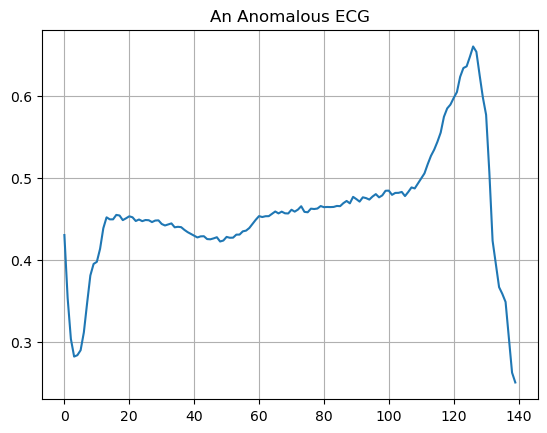

In [25]:
# Plot an anomalous ECG signal
plt.figure()
plt.grid()
plt.plot(anomalous_train_data[0].numpy())
plt.title("An Anomalous ECG")
plt.show()

In [26]:
# Define the Anomaly Detector model (Autoencoder)
class AnomalyDetector(nn.Module):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(140, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 140),
            nn.Sigmoid()  # Using sigmoid to bound the output between 0 and 1
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [27]:
# Define loss function and optimizer
criterion = nn.L1Loss()  # MAE
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.



In [28]:
# Prepare DataLoader for normal data
train_dataset_ad = TensorDataset(normal_train_data, normal_train_data)
test_dataset_ad = TensorDataset(test_data, test_data)  # Using all test data for validation

train_loader_ad = DataLoader(train_dataset_ad, batch_size=1024, shuffle=True)
test_loader_ad = DataLoader(test_dataset_ad, batch_size=1024, shuffle=False)

train_losses = []
val_losses = []

# Training loop
num_epochs = 1000
autoencoder.train()
for epoch in range(num_epochs):
    train_loss = 0
    for data, _ in train_loader_ad:
        optimizer.zero_grad()
        outputs = autoencoder(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    train_loss /= len(train_loader_ad.dataset)
    train_losses.append(train_loss)
    
    # Validation loss
    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in test_loader_ad:
            outputs = autoencoder(data)
            loss = criterion(outputs, data)
            val_loss += loss.item() * data.size(0)
    val_loss /= len(test_loader_ad.dataset)
    val_losses.append(val_loss)
    
    autoencoder.train()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [100/1000], Train Loss: 0.0184, Val Loss: 0.0298
Epoch [200/1000], Train Loss: 0.0165, Val Loss: 0.0294
Epoch [300/1000], Train Loss: 0.0162, Val Loss: 0.0289
Epoch [400/1000], Train Loss: 0.0147, Val Loss: 0.0270
Epoch [500/1000], Train Loss: 0.0135, Val Loss: 0.0277
Epoch [600/1000], Train Loss: 0.0133, Val Loss: 0.0276
Epoch [700/1000], Train Loss: 0.0130, Val Loss: 0.0269
Epoch [800/1000], Train Loss: 0.0125, Val Loss: 0.0250
Epoch [900/1000], Train Loss: 0.0119, Val Loss: 0.0218
Epoch [1000/1000], Train Loss: 0.0115, Val Loss: 0.0207


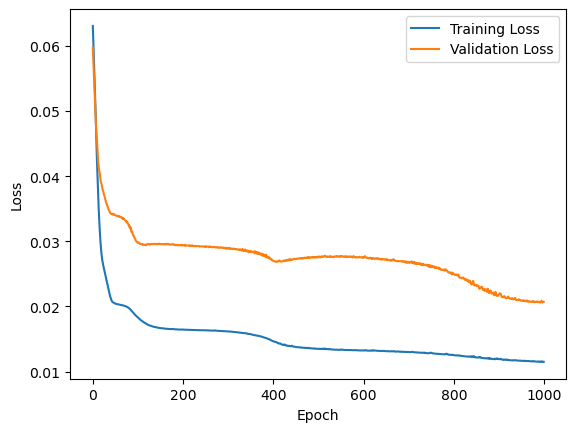

In [29]:
# Plot the losses
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

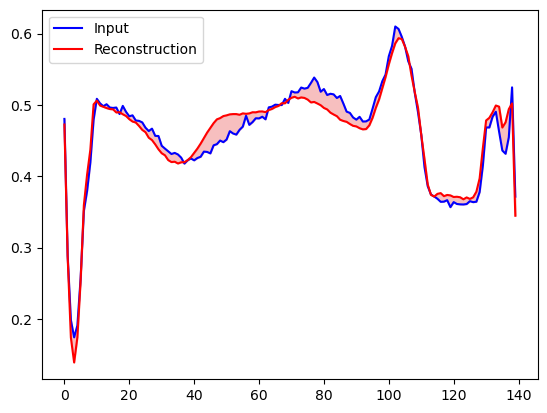

In [30]:
# Visualize reconstruction error for a normal test example
autoencoder.eval()
with torch.no_grad():
    sample = normal_test_data[0].unsqueeze(0)  # Shape: [1, 140]
    reconstructed = autoencoder(sample).squeeze().numpy()
    original = sample.squeeze().numpy()

plt.figure()
plt.plot(original, 'b', label='Input')
plt.plot(reconstructed, 'r', label='Reconstruction')
plt.fill_between(np.arange(140), reconstructed, original, color='lightcoral', alpha=0.5)
plt.legend()
plt.show()

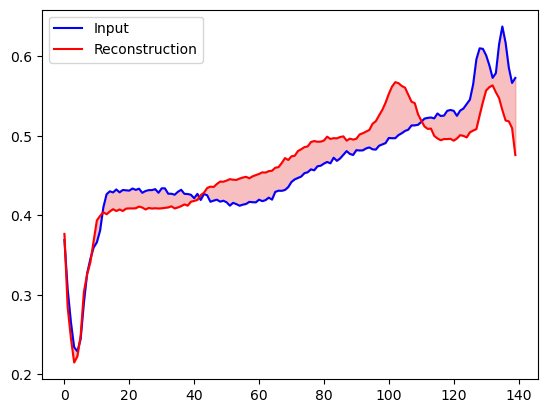

In [31]:
# Visualize reconstruction error for an anomalous test example
autoencoder.eval()
with torch.no_grad():
    sample = anomalous_test_data[0].unsqueeze(0)  # Shape: [1, 140]
    reconstructed = autoencoder(sample).squeeze().numpy()
    original = sample.squeeze().numpy()

plt.figure()
plt.plot(original, 'b', label='Input')
plt.plot(reconstructed, 'r', label='Reconstruction')
plt.fill_between(np.arange(140), reconstructed, original, color='lightcoral', alpha=0.5)
plt.legend()
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

Plot the reconstruction error on normal ECGs from the training set

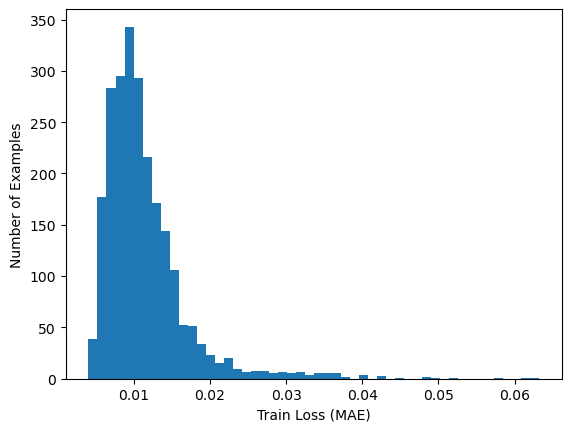

In [32]:
# Compute reconstruction loss on training data and plot histogram
autoencoder.eval()
with torch.no_grad():
    reconstructions = autoencoder(normal_train_data).numpy()
    train_loss = np.mean(np.abs(reconstructions - normal_train_data.numpy()), axis=1)

plt.hist(train_loss, bins=50)
plt.xlabel("Train Loss (MAE)")
plt.ylabel("Number of Examples")
plt.show()

In [33]:
# Choose a threshold value one standard deviation above the mean
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold:", threshold)

Threshold: 0.017334666


If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the precision and recall of your classifier.

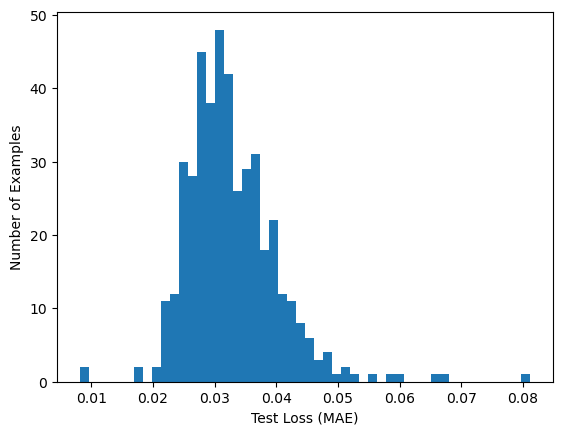

In [34]:
# Compute reconstruction loss on anomalous test data and plot histogram
autoencoder.eval()
with torch.no_grad():
    reconstructions = autoencoder(anomalous_test_data).numpy()
    test_loss = np.mean(np.abs(reconstructions - anomalous_test_data.numpy()), axis=1)

plt.hist(test_loss, bins=50)
plt.xlabel("Test Loss (MAE)")
plt.ylabel("Number of Examples")
plt.show()

In [35]:
# Define prediction and evaluation functions
def predict(model, data, threshold):
    model.eval()
    with torch.no_grad():
        reconstructions = model(data).numpy()
        loss = np.mean(np.abs(reconstructions - data.numpy()), axis=1)
    return loss > threshold  # Anomaly if loss > threshold

def print_stats(predictions, labels):
    acc = accuracy_score(labels, predictions)
    prec = precision_score(labels, predictions)
    rec = recall_score(labels, predictions)
    print(f"Accuracy = {acc:.4f}")
    print(f"Precision = {prec:.4f}")
    print(f"Recall = {rec:.4f}")

In [36]:
# Make predictions on test data and print statistics
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels.numpy())

Accuracy = 0.0540
Precision = 0.1045
Recall = 0.0911


# Variational Autoencoder

In this tutroial we will develop a convolutional variational autoencoder (VAE).

A variational autoencoder,also known as VAE, is the artificial neural network architecture introduced by Diederik P Kingma and Max Welling, belonging to the families of probabilistic graphical models and variational Bayesian methods.

https://arxiv.org/pdf/1312.6114.pdf


    ''' How can we perform efficient inference and learning in directed probabilistic
    models, in the presence of continuous latent variables with intractable posterior
    distributions, and large datasets? We introduce a stochastic variational inference
            and learning algorithm that scales to large datasets and, under some mild differentiability conditions, even works in the intractable case. '''

We demonstrate such apporach on the MNIST dataset by taking high dimensional input data and compresses it into a smaller representation

Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a Gaussian. This approach produces a continuous, structured latent space, which is useful for image generation.


<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" alt="Diagram of one-hot encodings" width="800" />

In [37]:
!pip install imageio

In [38]:
# Import additional libraries for image handling and visualization
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import time

In [39]:
# Load the MNIST dataset using torchvision
transform = transforms.ToTensor()

train_dataset_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_images = train_dataset_mnist.data.float() / 255.0  # Shape: [60000, 28, 28]
test_images = test_dataset_mnist.data.float() / 255.0    # Shape: [10000, 28, 28]

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 125933958.86it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 24838157.44it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 82186257.67it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4198001.05it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [40]:
# Preprocess the MNIST data
def preprocess_images(images):
    images = images.unsqueeze(1) / 1.0  # Add channel dimension and normalize to [0,1]
    images = torch.where(images > 0.5, torch.ones_like(images), torch.zeros_like(images))
    return images.float()

train_images = preprocess_images(train_images)  # Shape: [60000, 1, 28, 28]
test_images = preprocess_images(test_images)    # Shape: [10000, 1, 28, 28]

In [41]:
# Specify dataset sizes and batch size
train_size = 60000
batch_size = 32
test_size = 10000

In [42]:
# Create DataLoaders for training and testing
train_dataset_cvae = TensorDataset(train_images)
test_dataset_cvae = TensorDataset(test_images)

train_loader_cvae = DataLoader(train_dataset_cvae, batch_size=batch_size, shuffle=True)
test_loader_cvae = DataLoader(test_dataset_cvae, batch_size=batch_size, shuffle=False)

## Now Let's define the encoder and decoder networks 

In this VAE example, use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. 
### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$.
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian.
Output log-variance instead of the variance directly for numerical stability.

### Decoder network
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use two convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.


In [43]:
# Define the Convolutional Variational Autoencoder (CVAE)
class CVAE(nn.Module):
    """Convolutional Variational Autoencoder."""
    
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # [32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # [64, 7, 7]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim * 2)  # Output: mean and logvar
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 7 * 7 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # [64, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [32, 28, 28]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)  # [1, 28, 28]
        )
        
    def encode(self, x):
        enc_out = self.encoder(x)
        mean, logvar = torch.chunk(enc_out, 2, dim=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = torch.sigmoid(logits)
            return probs
        return logits
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)
    
    def sample(self, z=None):
        if z is None:
            z = torch.randn(100, self.latent_dim)
        return self.decode(z, apply_sigmoid=True)


## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

Note: You could also analytically compute the KL term, but here you incorporate all three terms in the Monte Carlo estimator for simplicity.

In [44]:
latent_dim = 2
# Initialize the CVAE model
model = CVAE(latent_dim)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define the loss function
# For CVAE, the loss includes reconstruction loss and KL divergence
def log_normal_pdf(sample, mean, logvar, dim=1):
    log2pi = torch.log(torch.tensor(2. * np.pi))
    return torch.sum(-0.5 * ((sample - mean) ** 2 * torch.exp(-logvar) + logvar + log2pi), dim=dim)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_entropy = F.binary_cross_entropy_with_logits(x_logit, x, reduction='none')
    logpx_z = -torch.sum(cross_entropy, dim=[1, 2, 3])
    logpz = log_normal_pdf(z, torch.zeros_like(z), torch.zeros_like(logvar))
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -torch.mean(logpx_z + logpz - logqz_x)


## Training

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* Note: Since you use the dataset loaded with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

### Generating images

* After training, it is time to generate some images
* Start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here, plot the probabilities of Bernoulli distributions

In [45]:
# Initialize training parameters
epochs = 10
num_examples_to_generate = 16

# Set the model to training mode
model.train()

CVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=3136, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=1568, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(32, 7, 7))
    (3): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [46]:
# Define a function to generate and save images
def generate_and_save_images(model, epoch, test_sample):
    model.eval()
    os.makedirs('runs', exist_ok=True)
    with torch.no_grad():
        mean, logvar = model.encode(test_sample)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i].squeeze().cpu(), cmap='gray')
        plt.axis('off')
    
    plt.savefig(f'runs/image_at_epoch_{epoch:04d}.png')
    plt.show()
    model.train()

In [47]:
# Prepare a sample of the test set for generating output images
# Select first `num_examples_to_generate` images from test set
test_batch = next(iter(test_loader_cvae))[0]
test_sample = test_batch[:num_examples_to_generate]

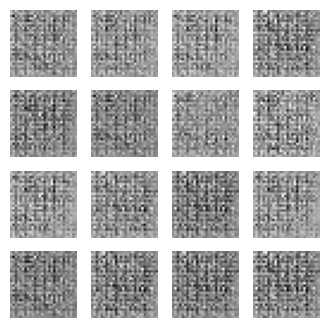

In [48]:
# Generate and save images before training (epoch 0)
generate_and_save_images(model, 0, test_sample)

Epoch: 10, Test set ELBO: -156.7462, Time Elapsed: 6.26 seconds


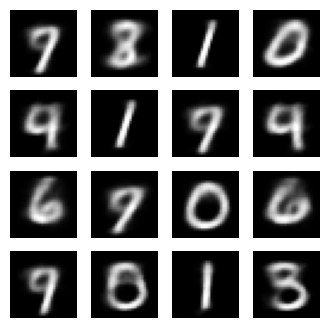

In [49]:
# Cell 48
# Train the CVAE model and generate images after each epoch

import time
from IPython import display  # For clearing output during training

model = model.to(device)

# Training loop
for epoch in range(1, epochs + 1):
    start_time = time.time()
    model.train()  # Set model to training mode
    train_loss = 0
    for batch in train_loader_cvae:
        inputs = batch[0].to(device)  # Move data to device
        
        optimizer.zero_grad()        # Clear gradients
        loss = compute_loss(model, inputs)  # Compute loss
        loss.backward()              # Backpropagate
        optimizer.step()             # Update parameters
        
        train_loss += loss.item() * inputs.size(0)  # Accumulate loss
    
    train_loss /= len(train_loader_cvae.dataset)  # Average training loss
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader_cvae:
            inputs = batch[0].to(device)  # Move data to device
            loss = compute_loss(model, inputs)  # Compute loss
            val_loss += loss.item() * inputs.size(0)  # Accumulate loss
    
    val_loss /= len(test_loader_cvae.dataset)  # Average validation loss
    elbo = -val_loss  # Evidence Lower Bound (ELBO)
    
    end_time = time.time()
    
    # Clear previous output (optional, for cleaner logs)
    display.clear_output(wait=False)
    
    # Print epoch statistics
    print(f'Epoch: {epoch}, Test set ELBO: {elbo:.4f}, Time Elapsed: {end_time - start_time:.2f} seconds')
    
    # Generate and save images for visualization
    generate_and_save_images(model, epoch, test_sample.to(device))


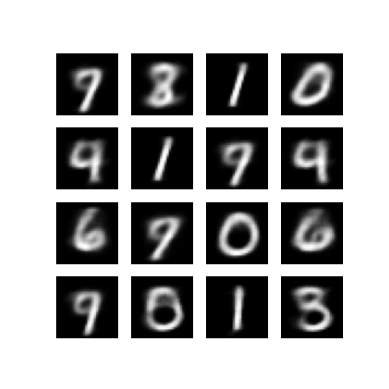

In [ ]:
# Display a generated image from the last training epoch
def display_image(epoch_no):
    return PIL.Image.open(f'runs/image_at_epoch_{epoch_no:04d}.png')

plt.figure()
plt.imshow(display_image(epochs), cmap='gray')
plt.axis('off')  # Hide axes
plt.show()

In [51]:
# Create an animated GIF of the generated images over epochs
anim_file = 'runs/cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = sorted(glob.glob('runs/image_at_epoch_*.png'))
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    # Append the last frame again
    image = imageio.imread(filenames[-1])
    writer.append_data(image)

/tmp/ipykernel_129624/1894869752.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_129624/1894869752.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filenames[-1])


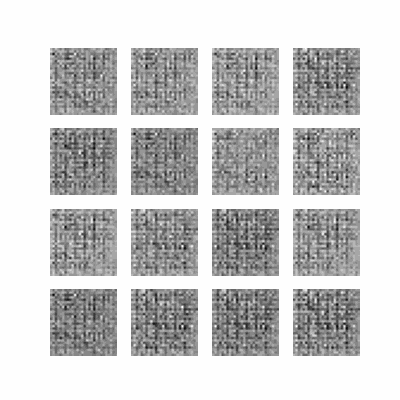

In [52]:
# Display the animated GIF
from IPython.display import Image
Image(open(anim_file, 'rb').read())

### Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space.

In [53]:
# Define a function to plot latent space images
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""
    model.eval()
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)
    image_width = digit_size * n
    image_height = digit_size * n
    image = np.zeros((image_height, image_width))
    
    with torch.no_grad():
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z = torch.tensor([[xi, yi]], dtype=torch.float32)
                x_decoded = model.sample(z)
                digit = x_decoded[0].squeeze().cpu().numpy()
                image[i * digit_size: (i + 1) * digit_size,
                      j * digit_size: (j + 1) * digit_size] = digit
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()
    model.train()

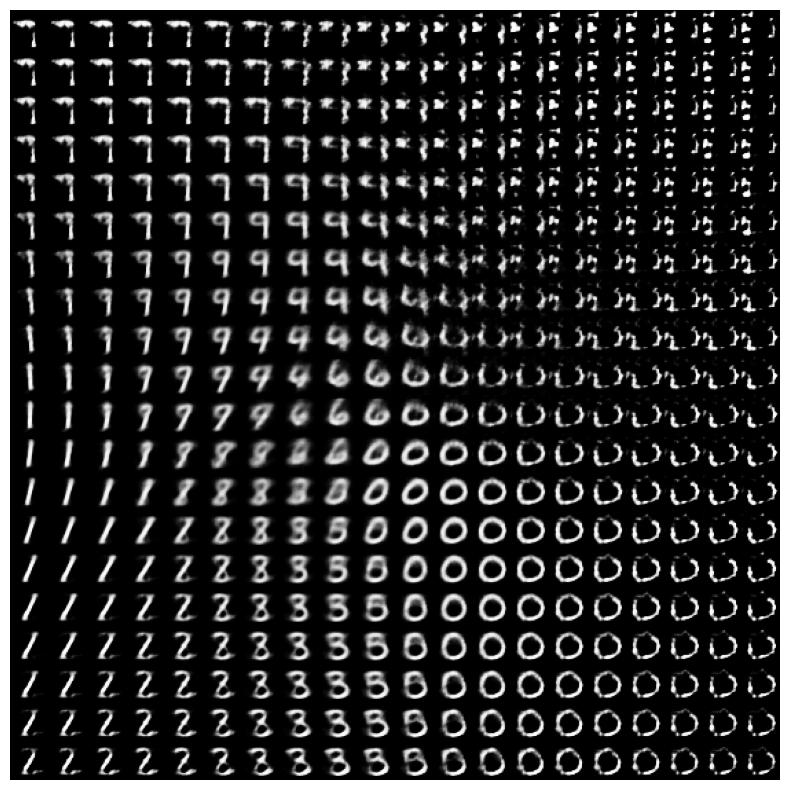

In [54]:
# Plot images decoded from the latent space grid
plot_latent_images(model.to('cpu'), 20)

# Advanced:  Adversarial training!

This is the concept of mapping the encoder’s output distribution $q(z|x)$ to an arbitrary prior distribution $p(z)$ using adversarial training (rather than variational inference).

Unfortunately, variational autoencoders often leave regions in the space of the prior distribution that do not map to realistic samples from the data. Adversarial autoencoders aim to improve this by encouraging the output of the encoder to fill the space of the prior distribution entirely, thereby allowing the decoder to generate realistic looking samples from any data point sampled from the prior. Instead of using variational inference, adversarial autoencoders do this by introducing two new components, namely the discriminator and the generator.

For every minibatch, there are three important events:

1. A minibatch of input vectors is encoded and decoded by the encoder and decoder, respectively, after which both the encoder and decoder are updated based on the standard reconstruction loss.
2. A minibatch of input vectors is transformed by the encoder, after which the minibatch is concatenated with code vectors sampled from the prior distribution. The discriminator is then updated using a binary cross-entropy loss based on its ability to separate those samples generated by the encoder from those sampled from the prior distribution.
3. A minibatch of input vectors is transformed by the encoder, the source of these data points is predicted by the discriminator, and the generator (which is also the encoder) is updated using a binary cross-entropy loss based on its ability to fool the discriminator into thinking the data points came from the prior distribution.



 First, the MNIST Dataset is imported

In [55]:
# Import additional libraries for Adversarial Autoencoder
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
def build_model_enc():
    model = nn.Sequential(
        # First Convolutional Layer
        nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),  # Output: [32, 28, 28]
        nn.ReLU(),
        # Second Convolutional Layer with Stride 2
        nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),  # Output: [64, 14, 14]
        nn.ReLU(),
        # Third Convolutional Layer with Stride 2
        nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),  # Output: [128, 7, 7]
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(128 * 7 * 7, 2)  # Latent space dimension is 2
    )
    return model

def build_model_dec():
    model = nn.Sequential(
        nn.Linear(2, 128 * 7 * 7),  # Mapping from latent space to feature maps
        nn.ReLU(),
        nn.Unflatten(1, (128, 7, 7)),  # Reshape to [128, 7, 7]
        # First Transposed Convolutional Layer
        nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),  # Output: [64, 7, 7]
        nn.ReLU(),
        # Upsampling Layer
        nn.Upsample(scale_factor=2, mode='nearest'),  # Output: [64, 14, 14]
        # Second Transposed Convolutional Layer
        nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2),  # Output: [32, 14, 14]
        nn.ReLU(),
        # Upsampling Layer
        nn.Upsample(scale_factor=2, mode='nearest'),  # Output: [32, 28, 28]
        # Final Convolutional Layer
        nn.Conv2d(32, 1, kernel_size=5, stride=1, padding=2),  # Output: [1, 28, 28]
        nn.Sigmoid()  # To ensure the output is between 0 and 1
    )
    return model

def build_model_disc():
    model = nn.Sequential(
        nn.Linear(2, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Sigmoid()  # Output probability between 0 and 1
    )
    return model


In [57]:
# Build and compile the Adversarial Autoencoder (AAE)
from torchsummary import summary

def build_model_aae():
    model_enc = build_model_enc().to(device)
    model_dec = build_model_dec().to(device)
    model_disc = build_model_disc().to(device)

    # Autoencoder Model: Encoder + Decoder
    model_ae = nn.Sequential(
        model_enc,
        model_dec
    ).to(device)
    
    # Encoder + Discriminator Model for adversarial training
    model_enc_disc = nn.Sequential(
        model_enc,
        model_disc
    ).to(device)
    
    return model_enc, model_dec, model_disc, model_ae, model_enc_disc

model_enc, model_dec, model_disc, model_ae, model_enc_disc = build_model_aae()

# Display model summaries
print("Encoder Summary:")
summary(model_enc, input_size=(1, 28, 28))

print("\nDecoder Summary:")
summary(model_dec, input_size=(2,))

print("\nDiscriminator Summary:")
summary(model_disc, input_size=(2,))

print("\nAutoencoder Summary:")
summary(model_ae, input_size=(1, 28, 28))

print("\nEncoder+Discriminator Summary:")
summary(model_enc_disc, input_size=(1, 28, 28))

Encoder Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 14, 14]          51,264
              ReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5            [-1, 128, 7, 7]         204,928
              ReLU-6            [-1, 128, 7, 7]               0
           Flatten-7                 [-1, 6272]               0
            Linear-8                    [-1, 2]          12,546
Total params: 269,570
Trainable params: 269,570
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.72
Params size (MB): 1.03
Estimated Total Size (MB): 1.75
----------------------------------------------------------------

Decoder Summary:
-------

In [58]:
# Define helper functions for image grid and setting model trainability
def imagegrid(dec, epochnumber):
    dec.eval()
    fig = plt.figure(figsize=[20, 20])
    
    with torch.no_grad():
        for i in range(-5, 5):
            for j in range(-5, 5):
                # Create a latent vector
                topred = torch.tensor([[i * 0.5, j * 0.5]], dtype=torch.float32).to(device)
                # Generate an image from the latent vector
                img = dec(topred).squeeze().cpu().numpy()
                # Add subplot
                ax = fig.add_subplot(10, 10, (i + 5) * 10 + (j + 5) + 1)
                ax.set_axis_off()
                ax.imshow(img, cmap="gray")
    
    # Save and display the image grid
    fig.savefig(f'runs/image_at_epoch_{epochnumber:04d}.png')
    plt.show()
    plt.close(fig)

Epoch 1: Reconstruction Loss: 0.1880, Adversarial Loss (Encoder): 1.0796, Adversarial Loss (Discriminator): 0.4947


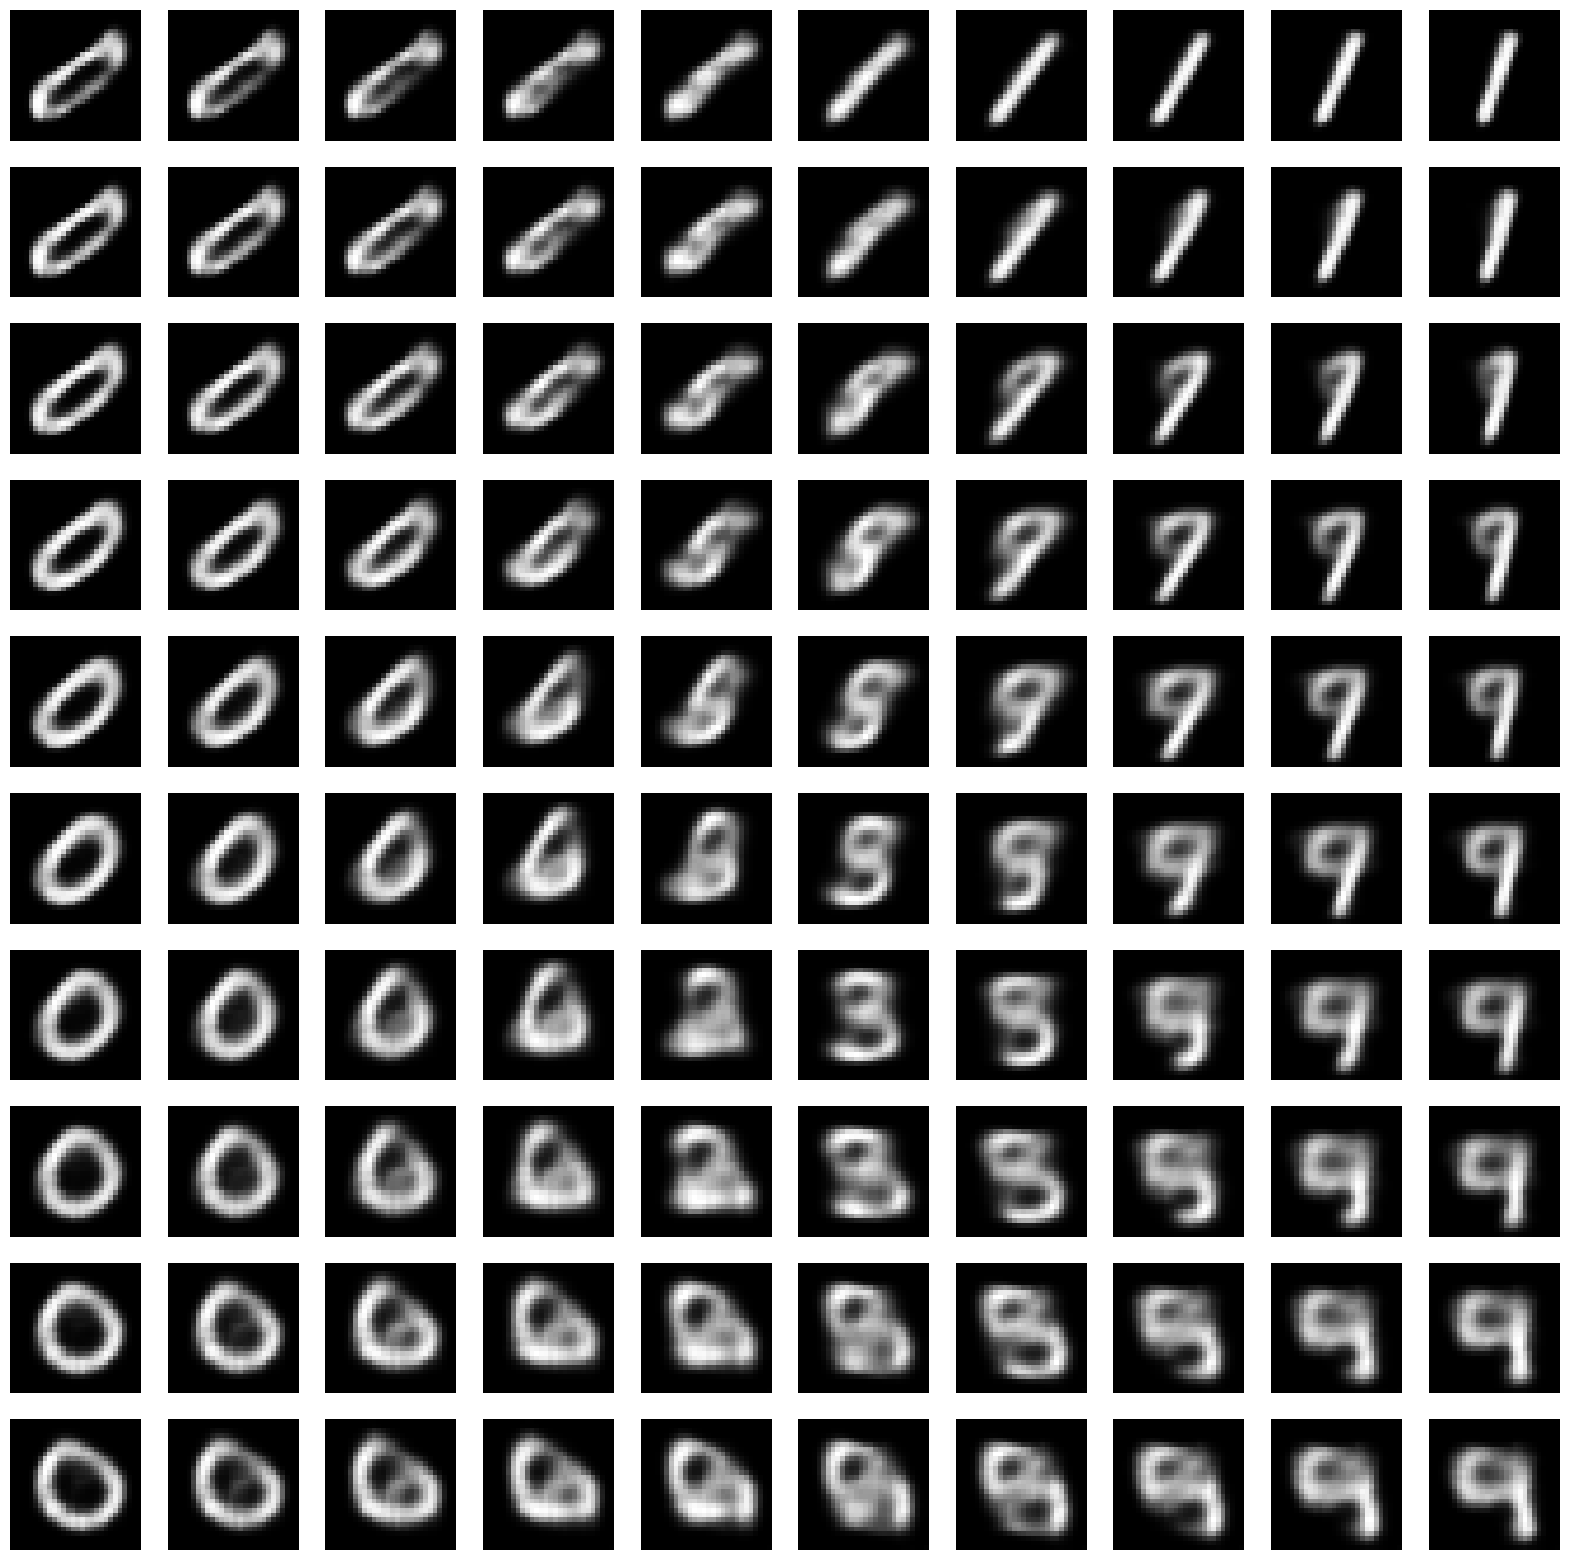

Epoch 2: Reconstruction Loss: 0.1853, Adversarial Loss (Encoder): 3.0640, Adversarial Loss (Discriminator): 0.0591


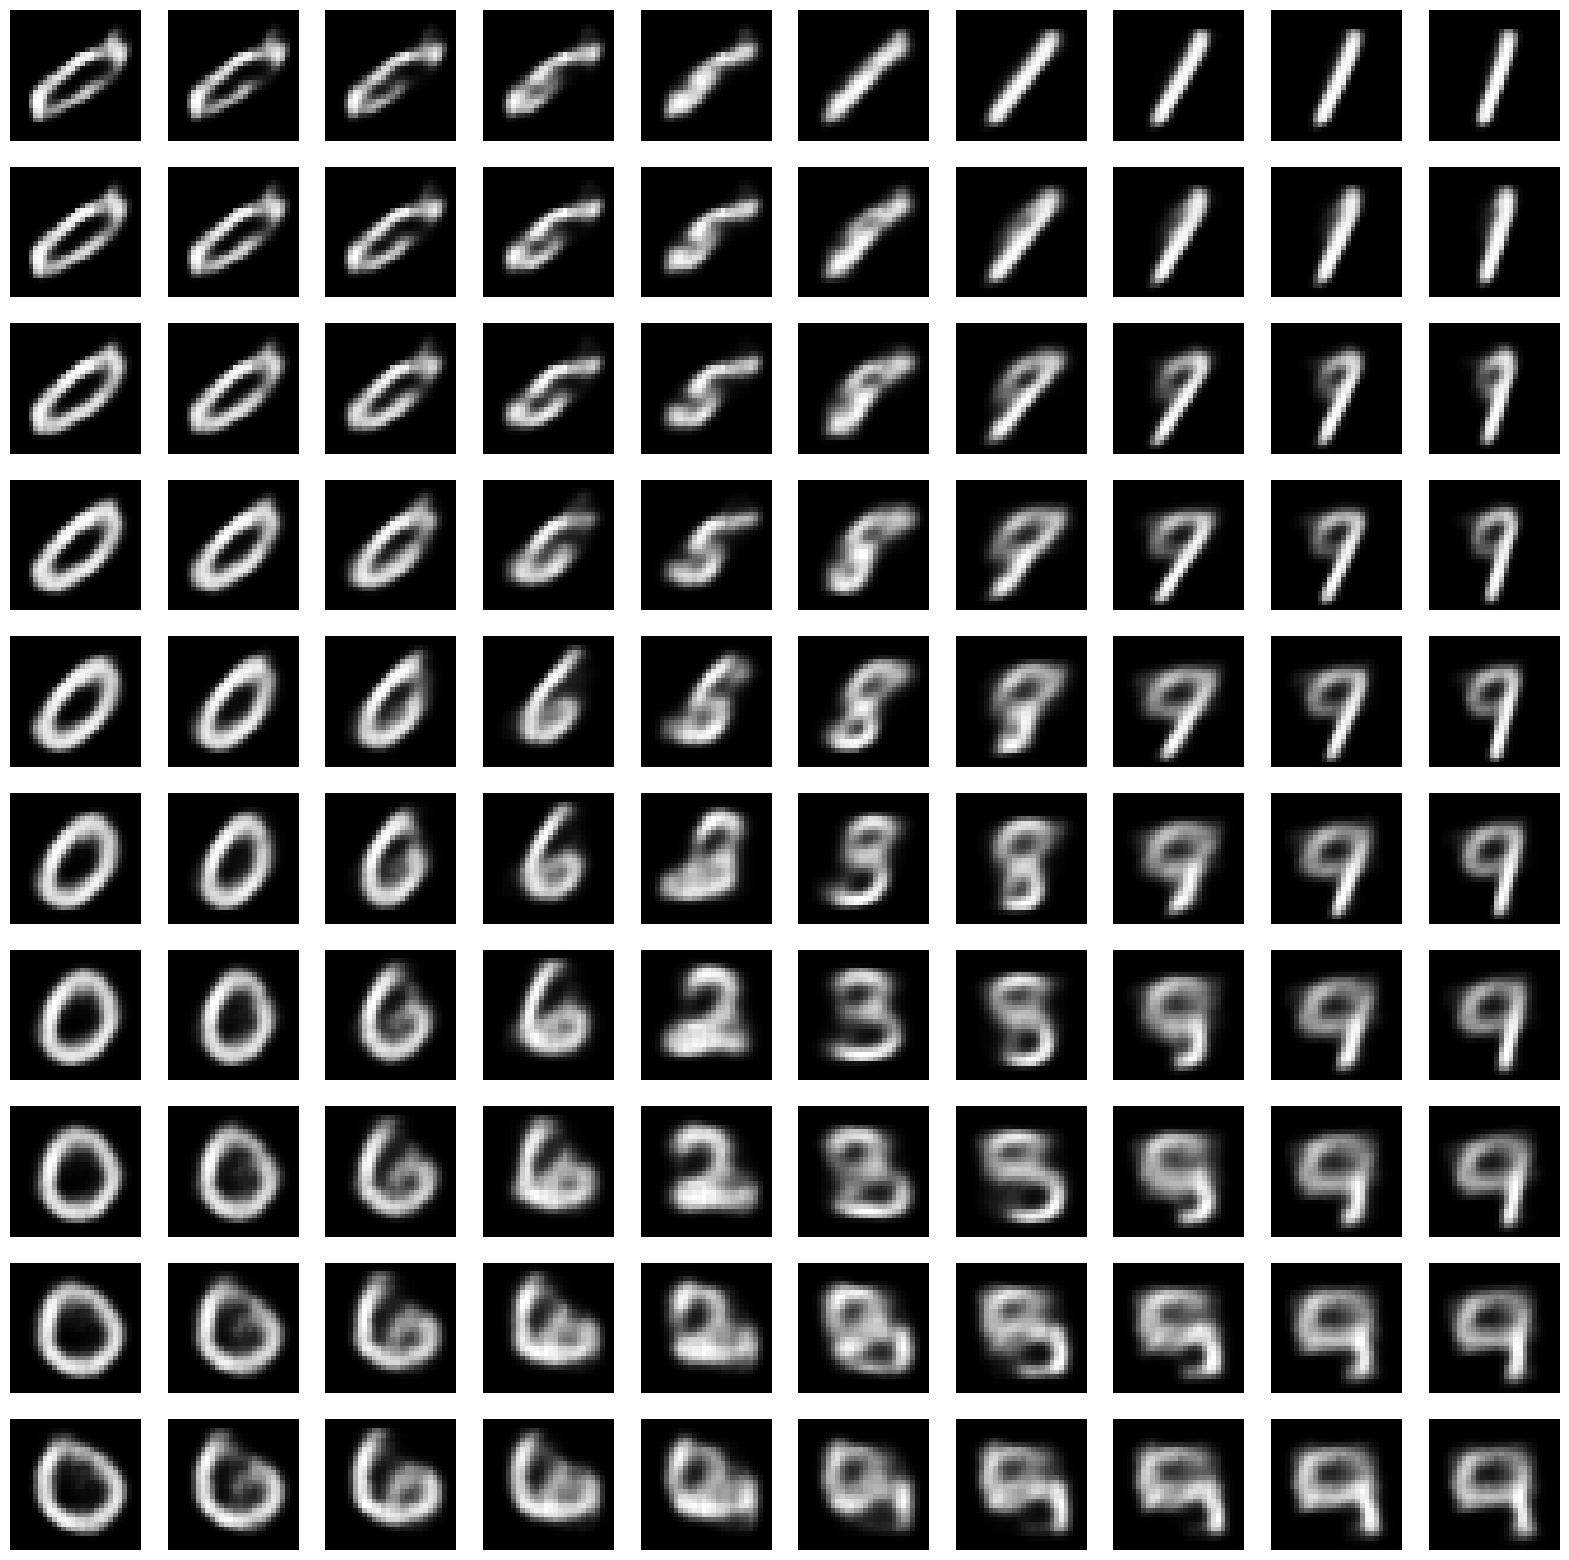

Epoch 3: Reconstruction Loss: 0.1722, Adversarial Loss (Encoder): 4.0613, Adversarial Loss (Discriminator): 0.0302


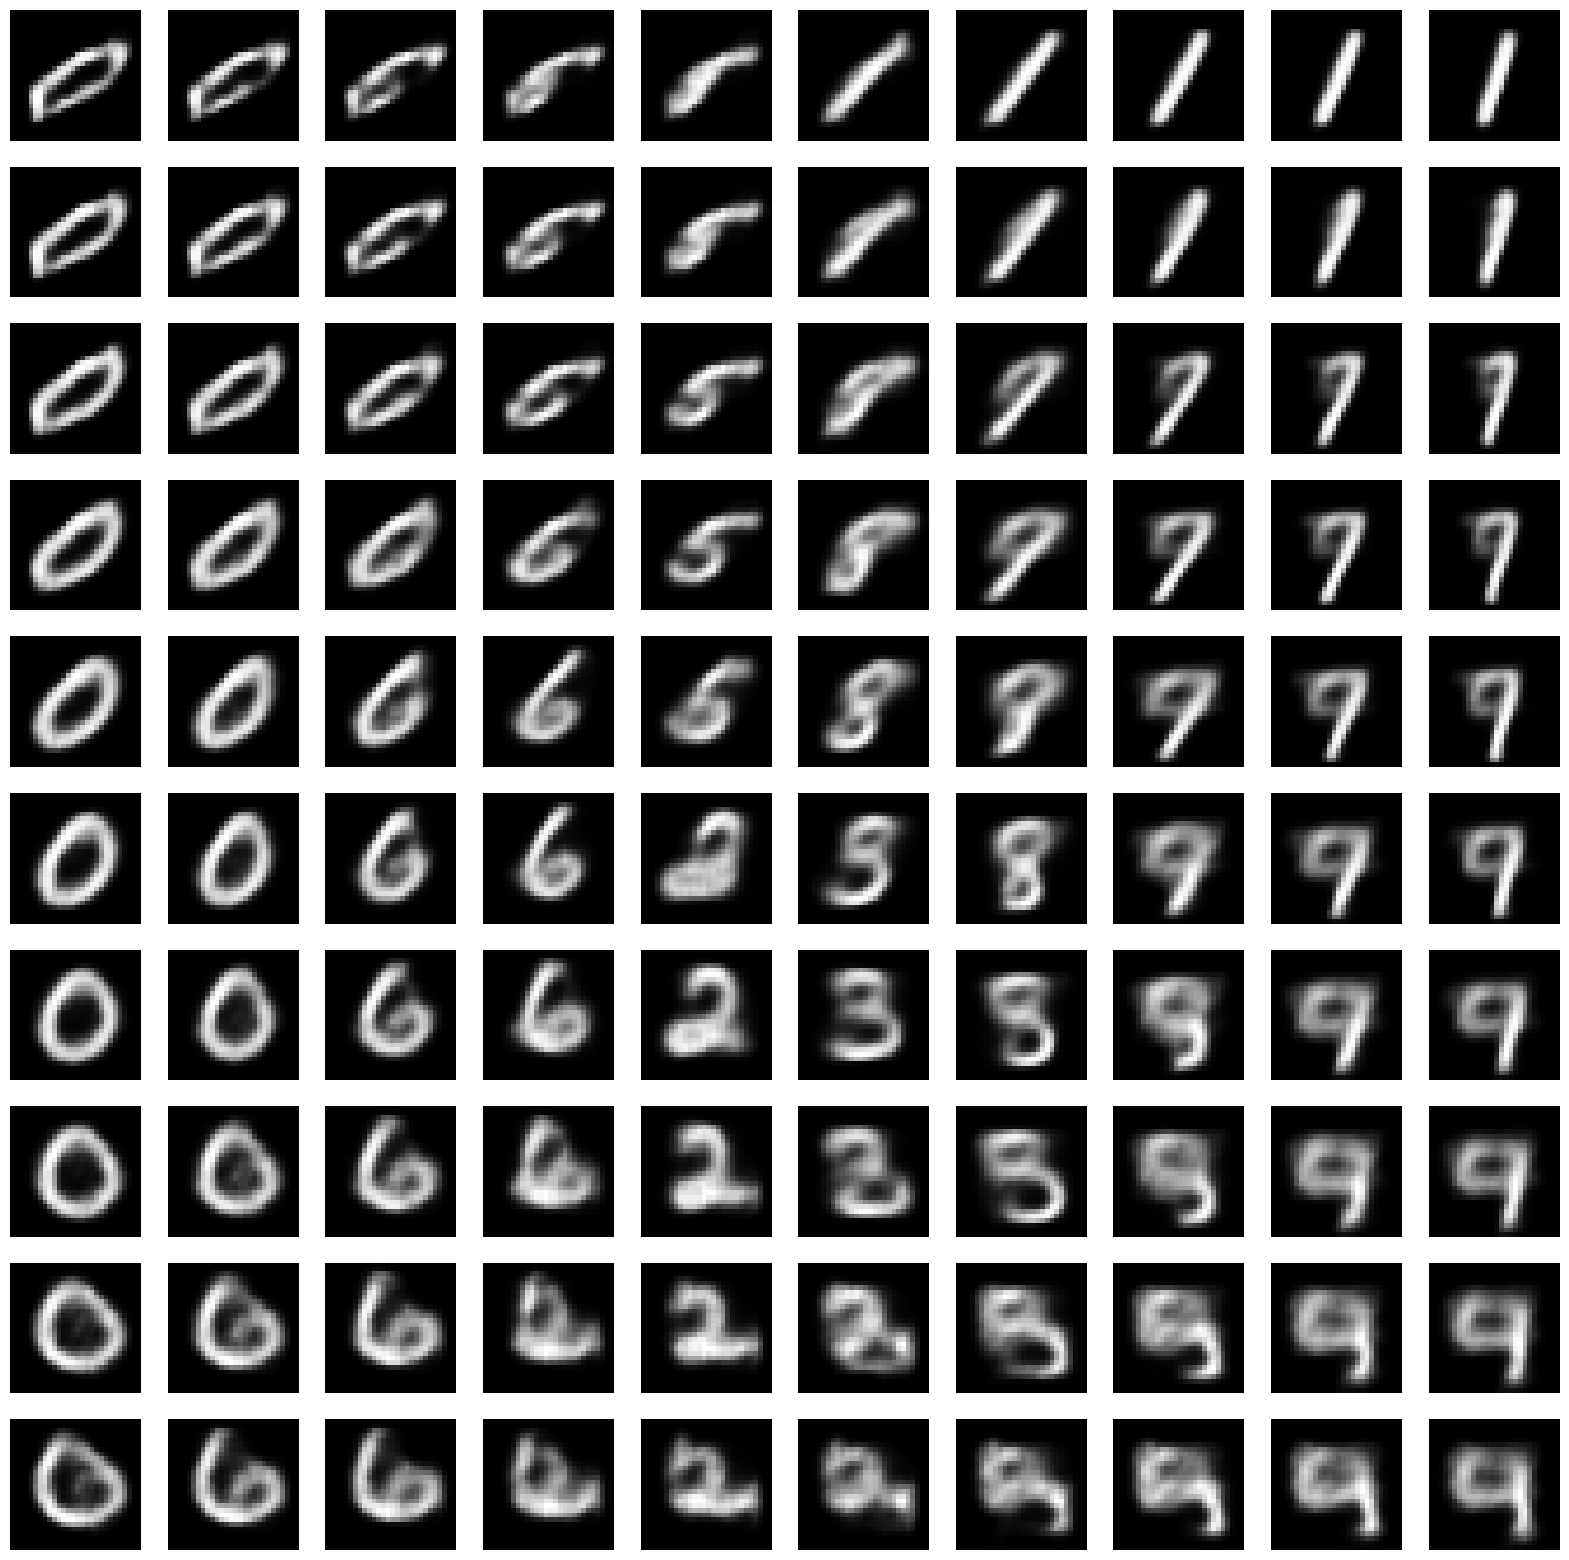

Epoch 4: Reconstruction Loss: 0.1723, Adversarial Loss (Encoder): 3.7020, Adversarial Loss (Discriminator): 0.0698


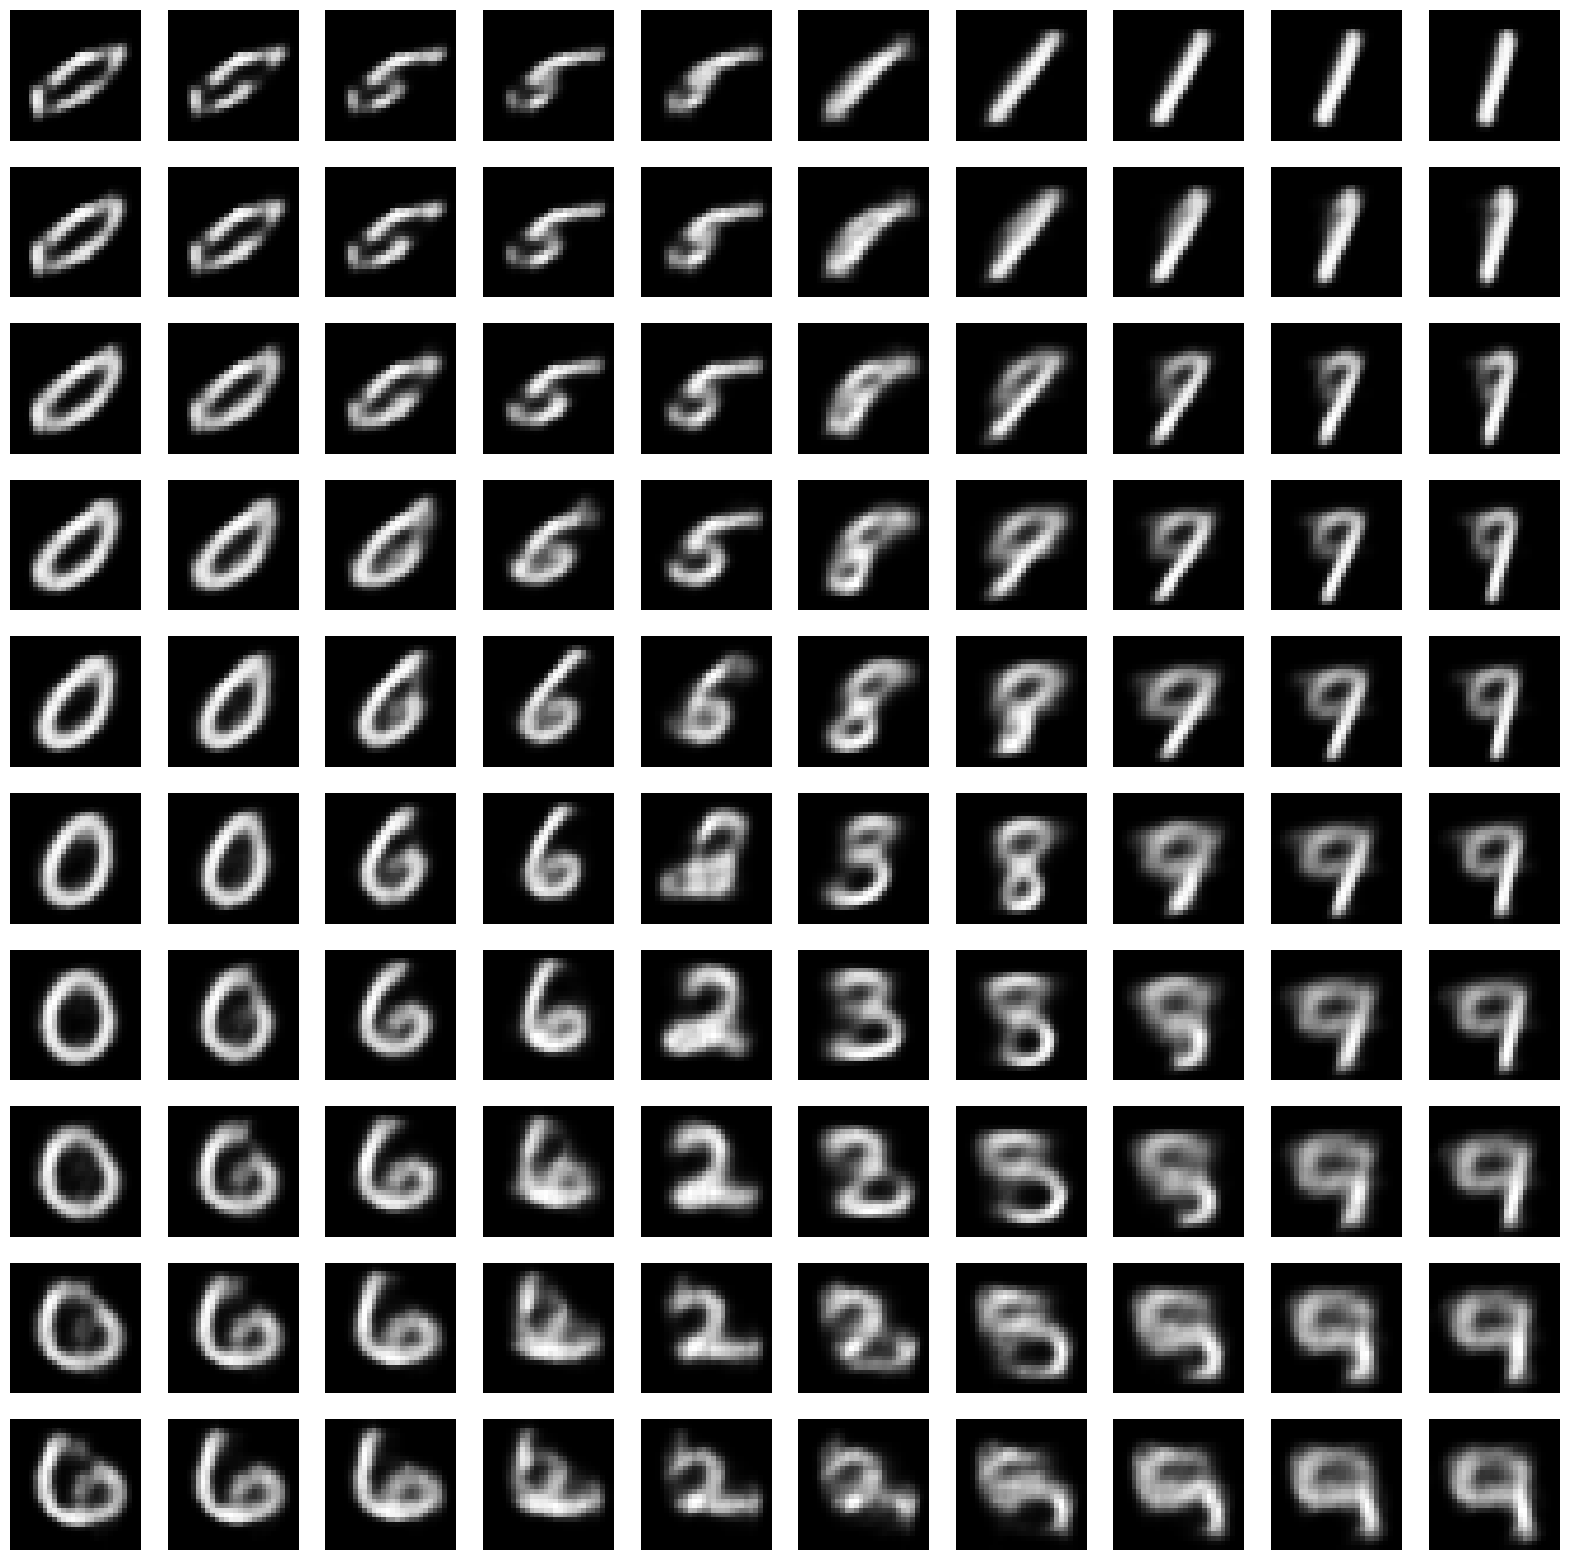

Epoch 5: Reconstruction Loss: 0.1812, Adversarial Loss (Encoder): 4.0994, Adversarial Loss (Discriminator): 0.0085


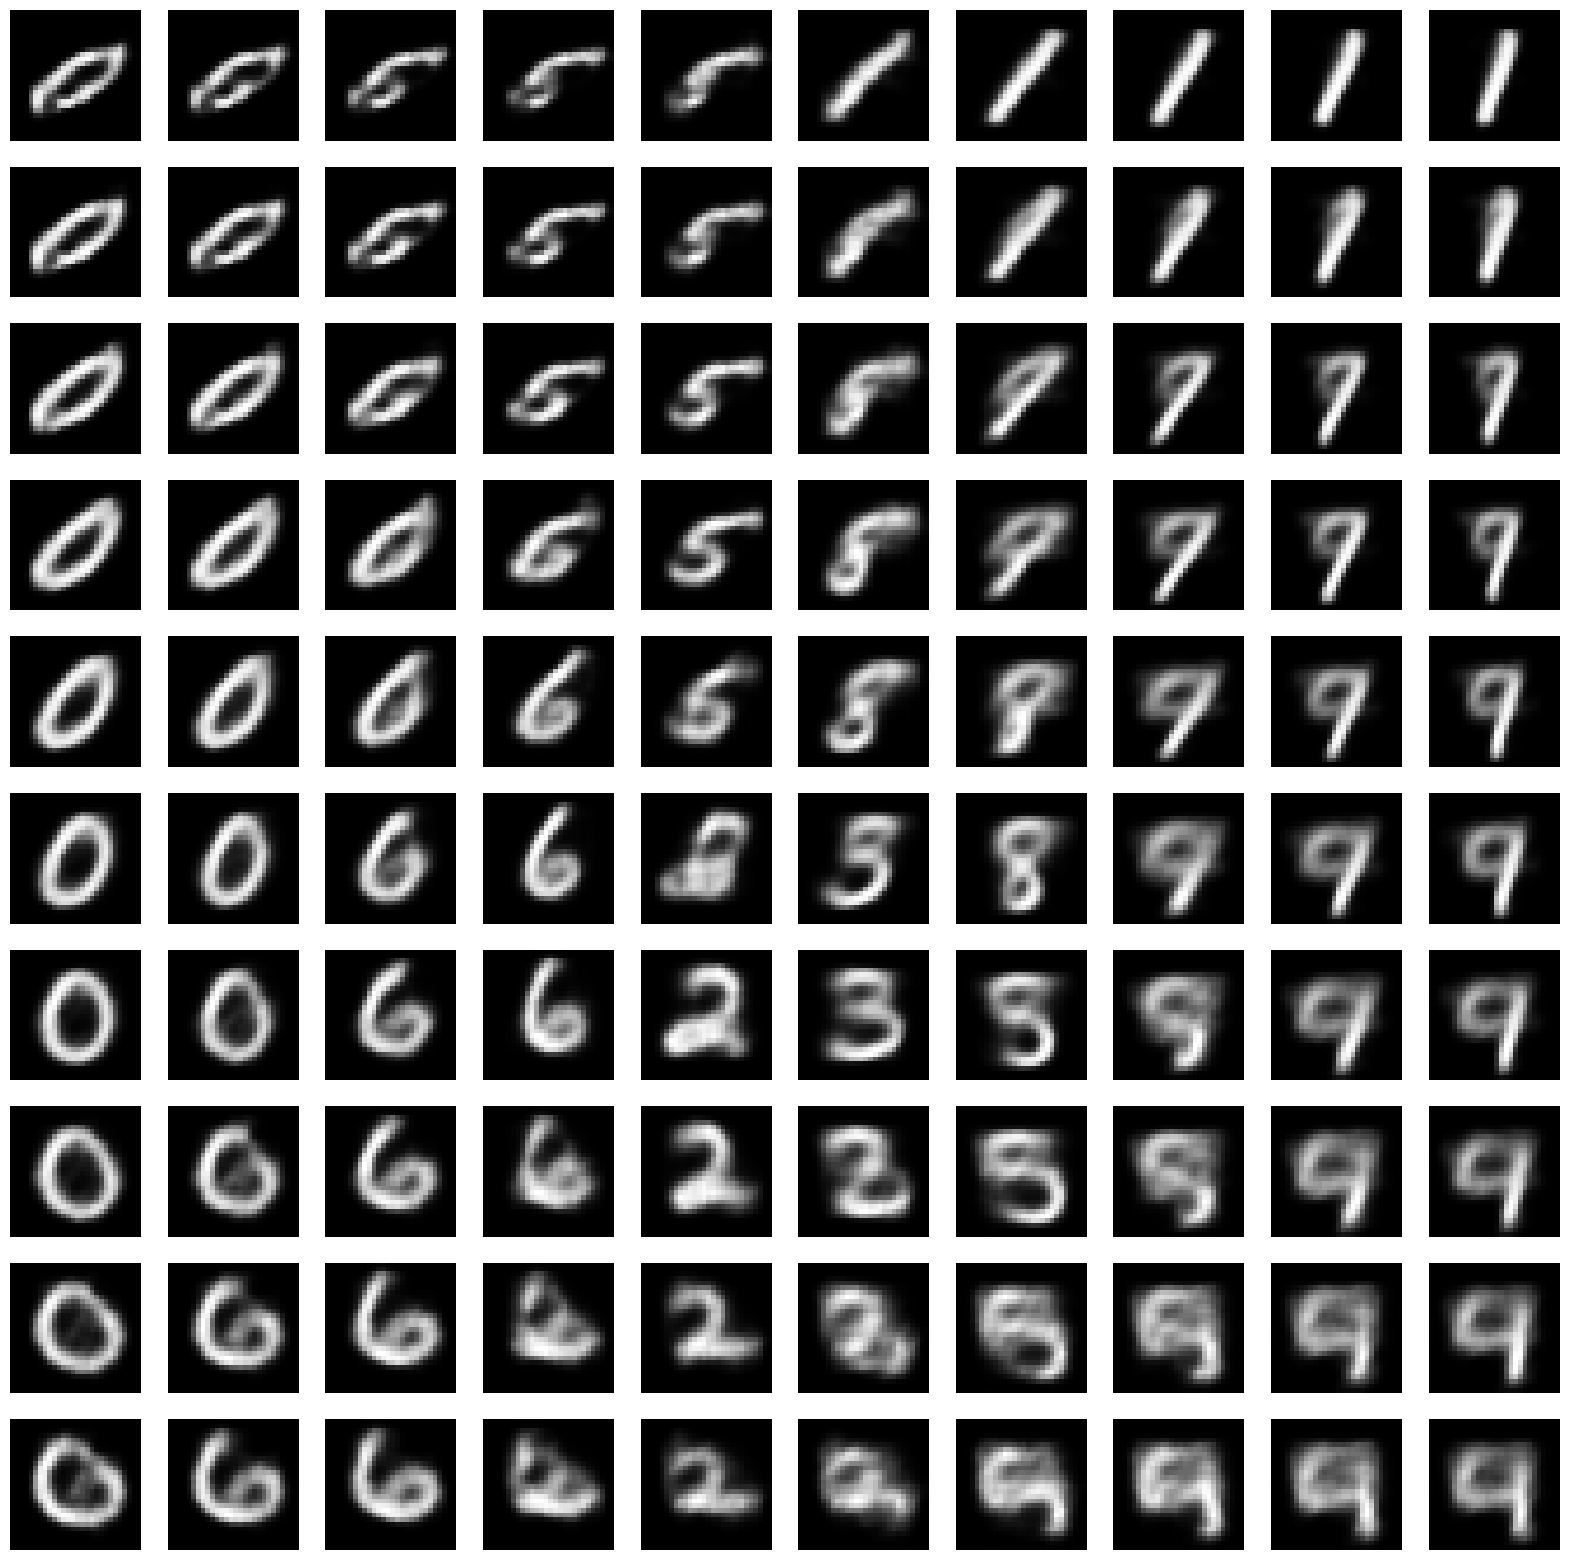

Epoch 6: Reconstruction Loss: 0.1944, Adversarial Loss (Encoder): 4.2989, Adversarial Loss (Discriminator): 0.0522


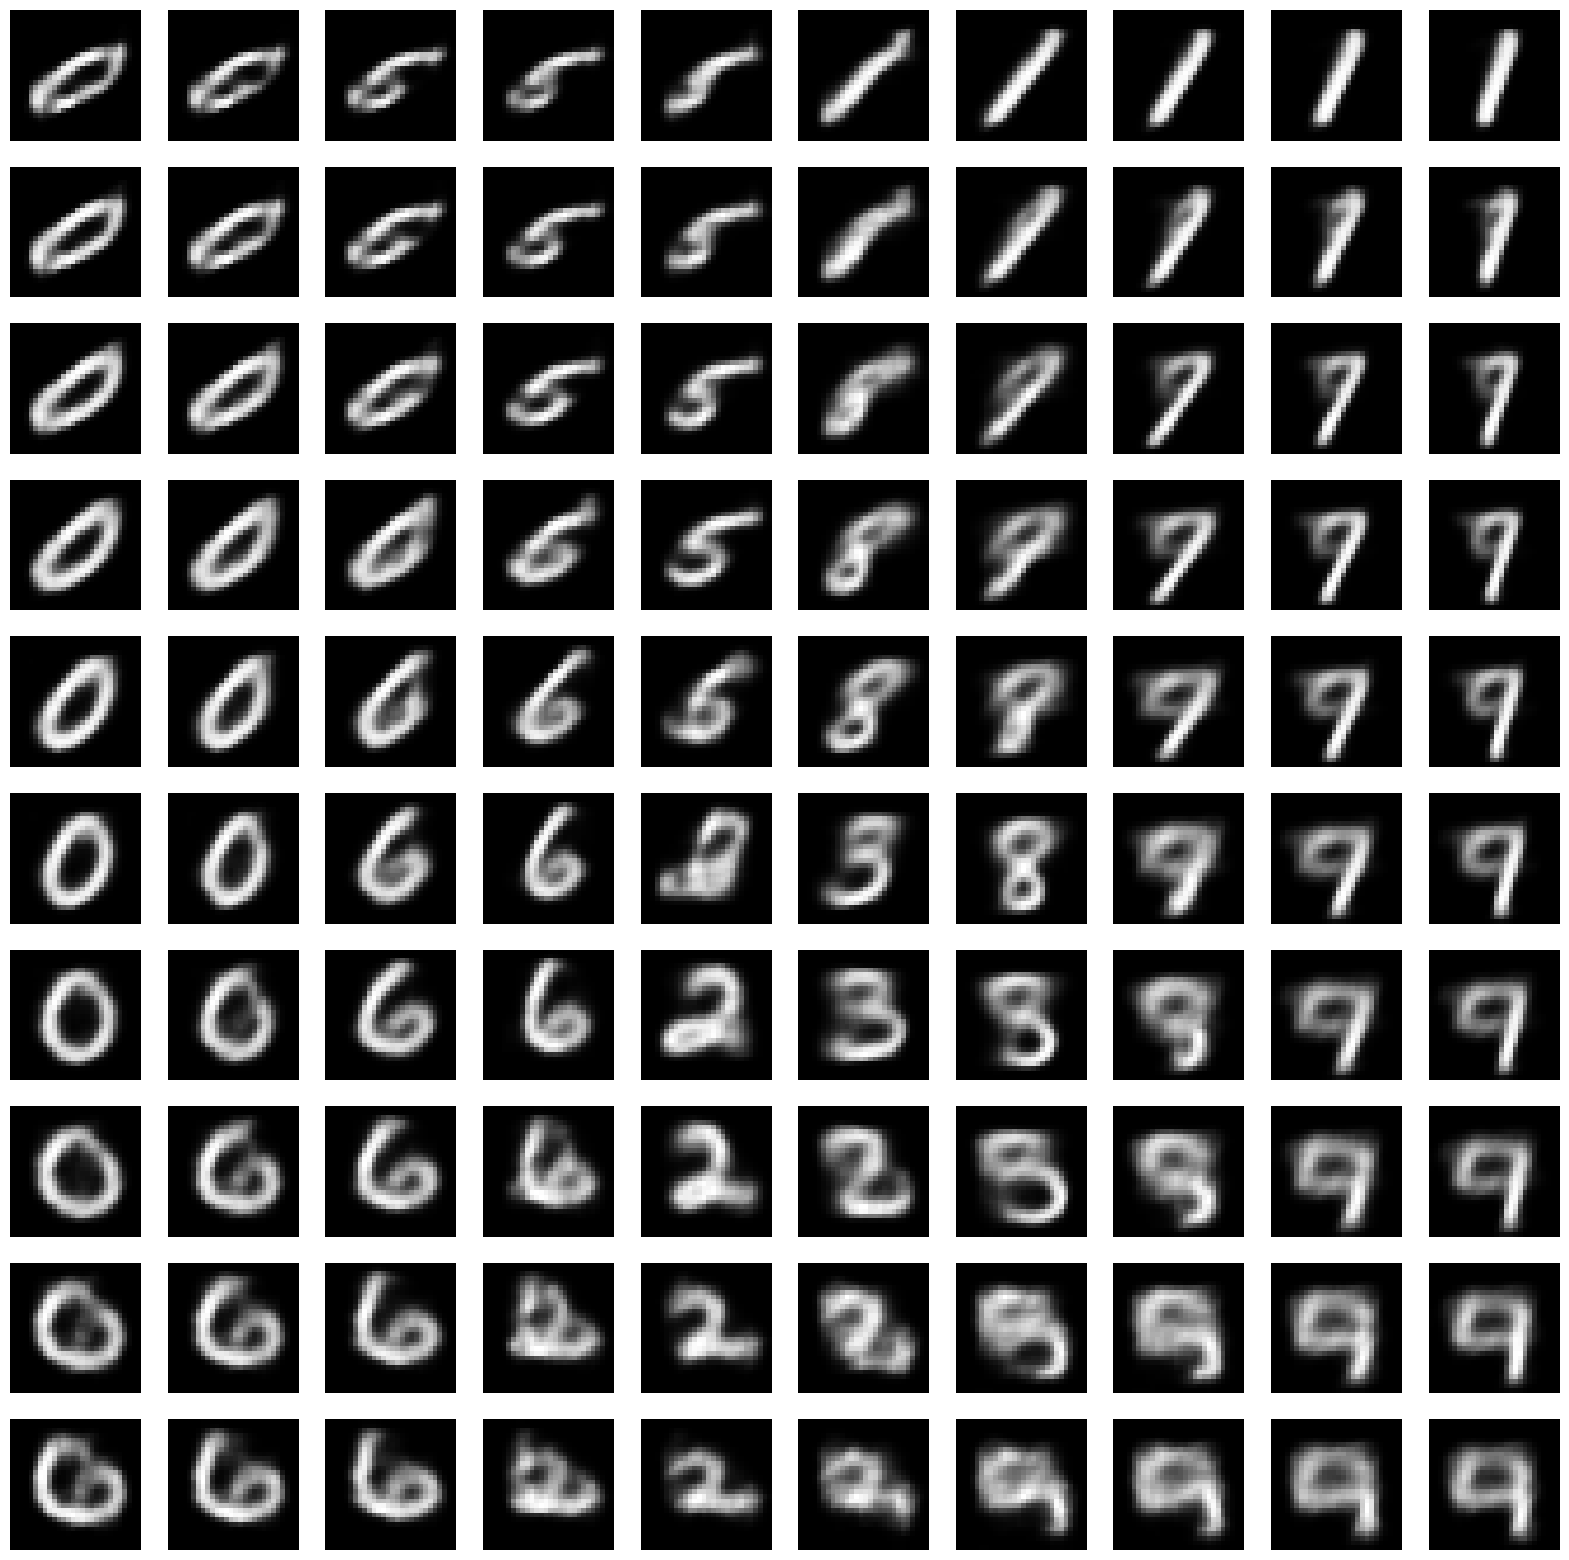

Epoch 7: Reconstruction Loss: 0.1873, Adversarial Loss (Encoder): 5.0144, Adversarial Loss (Discriminator): 0.0044


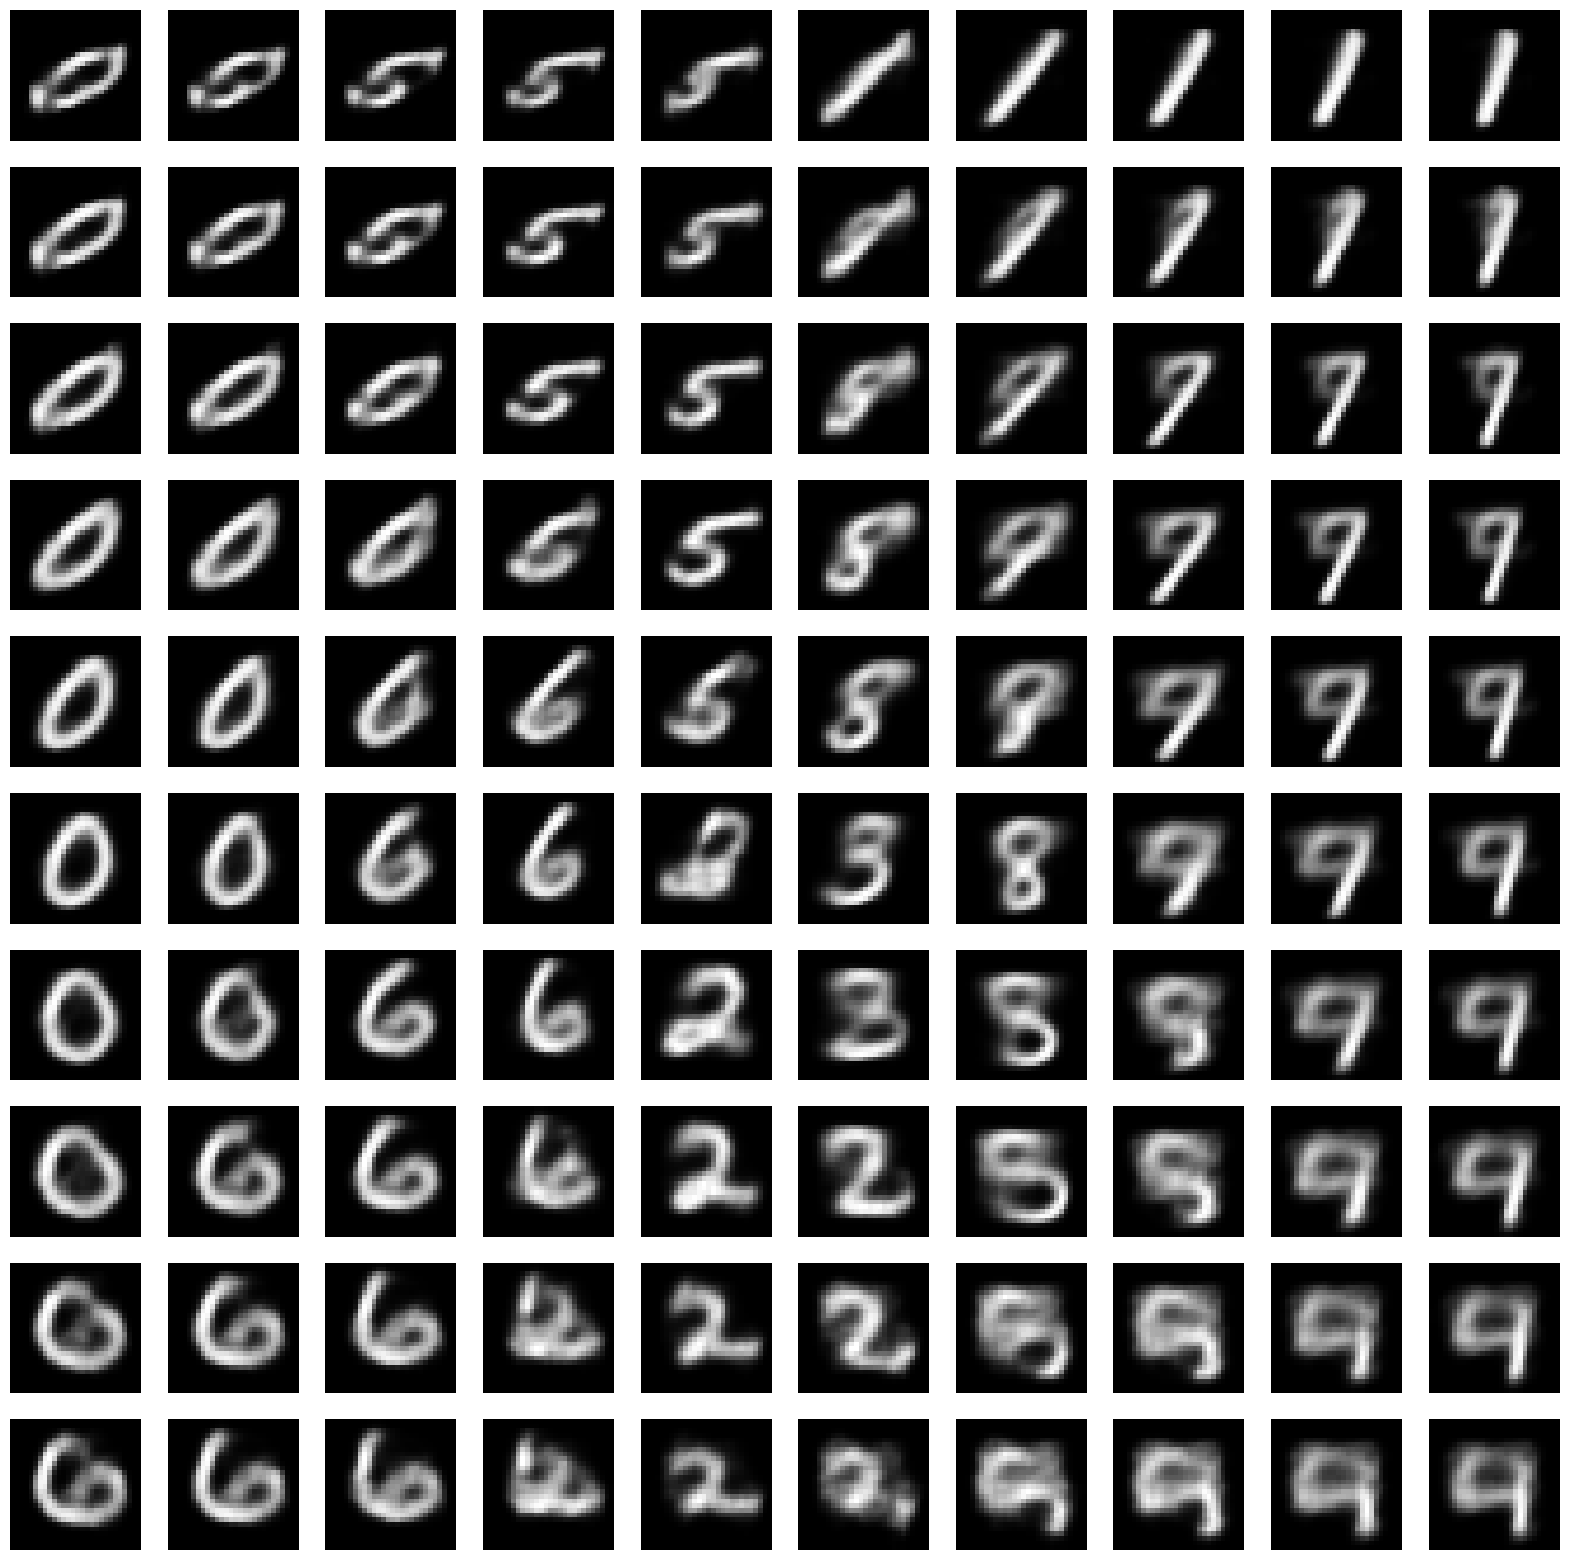

Epoch 8: Reconstruction Loss: 0.1752, Adversarial Loss (Encoder): 5.6807, Adversarial Loss (Discriminator): 0.0148


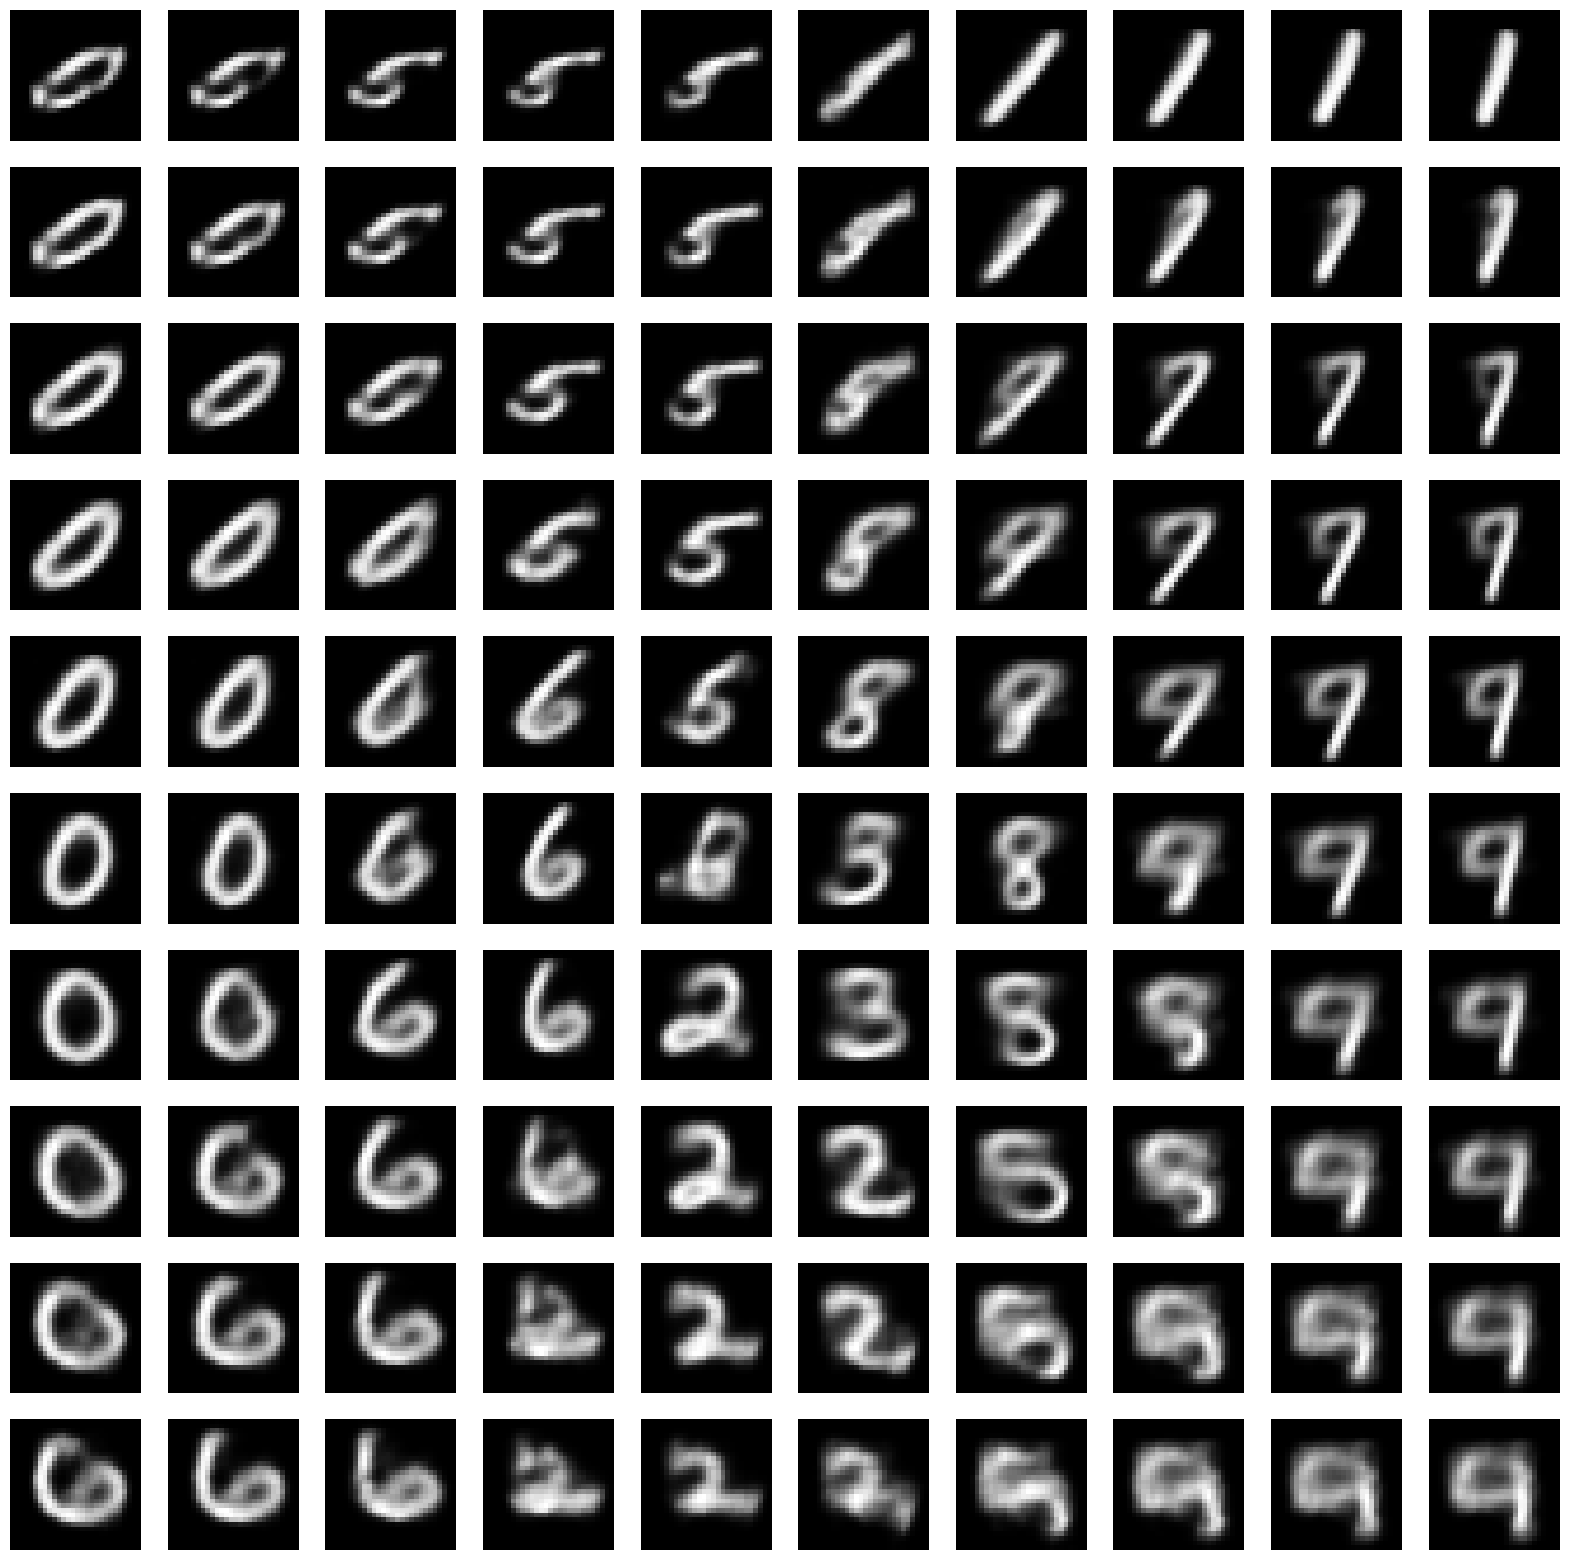

Epoch 9: Reconstruction Loss: 0.1822, Adversarial Loss (Encoder): 6.0309, Adversarial Loss (Discriminator): 0.0157


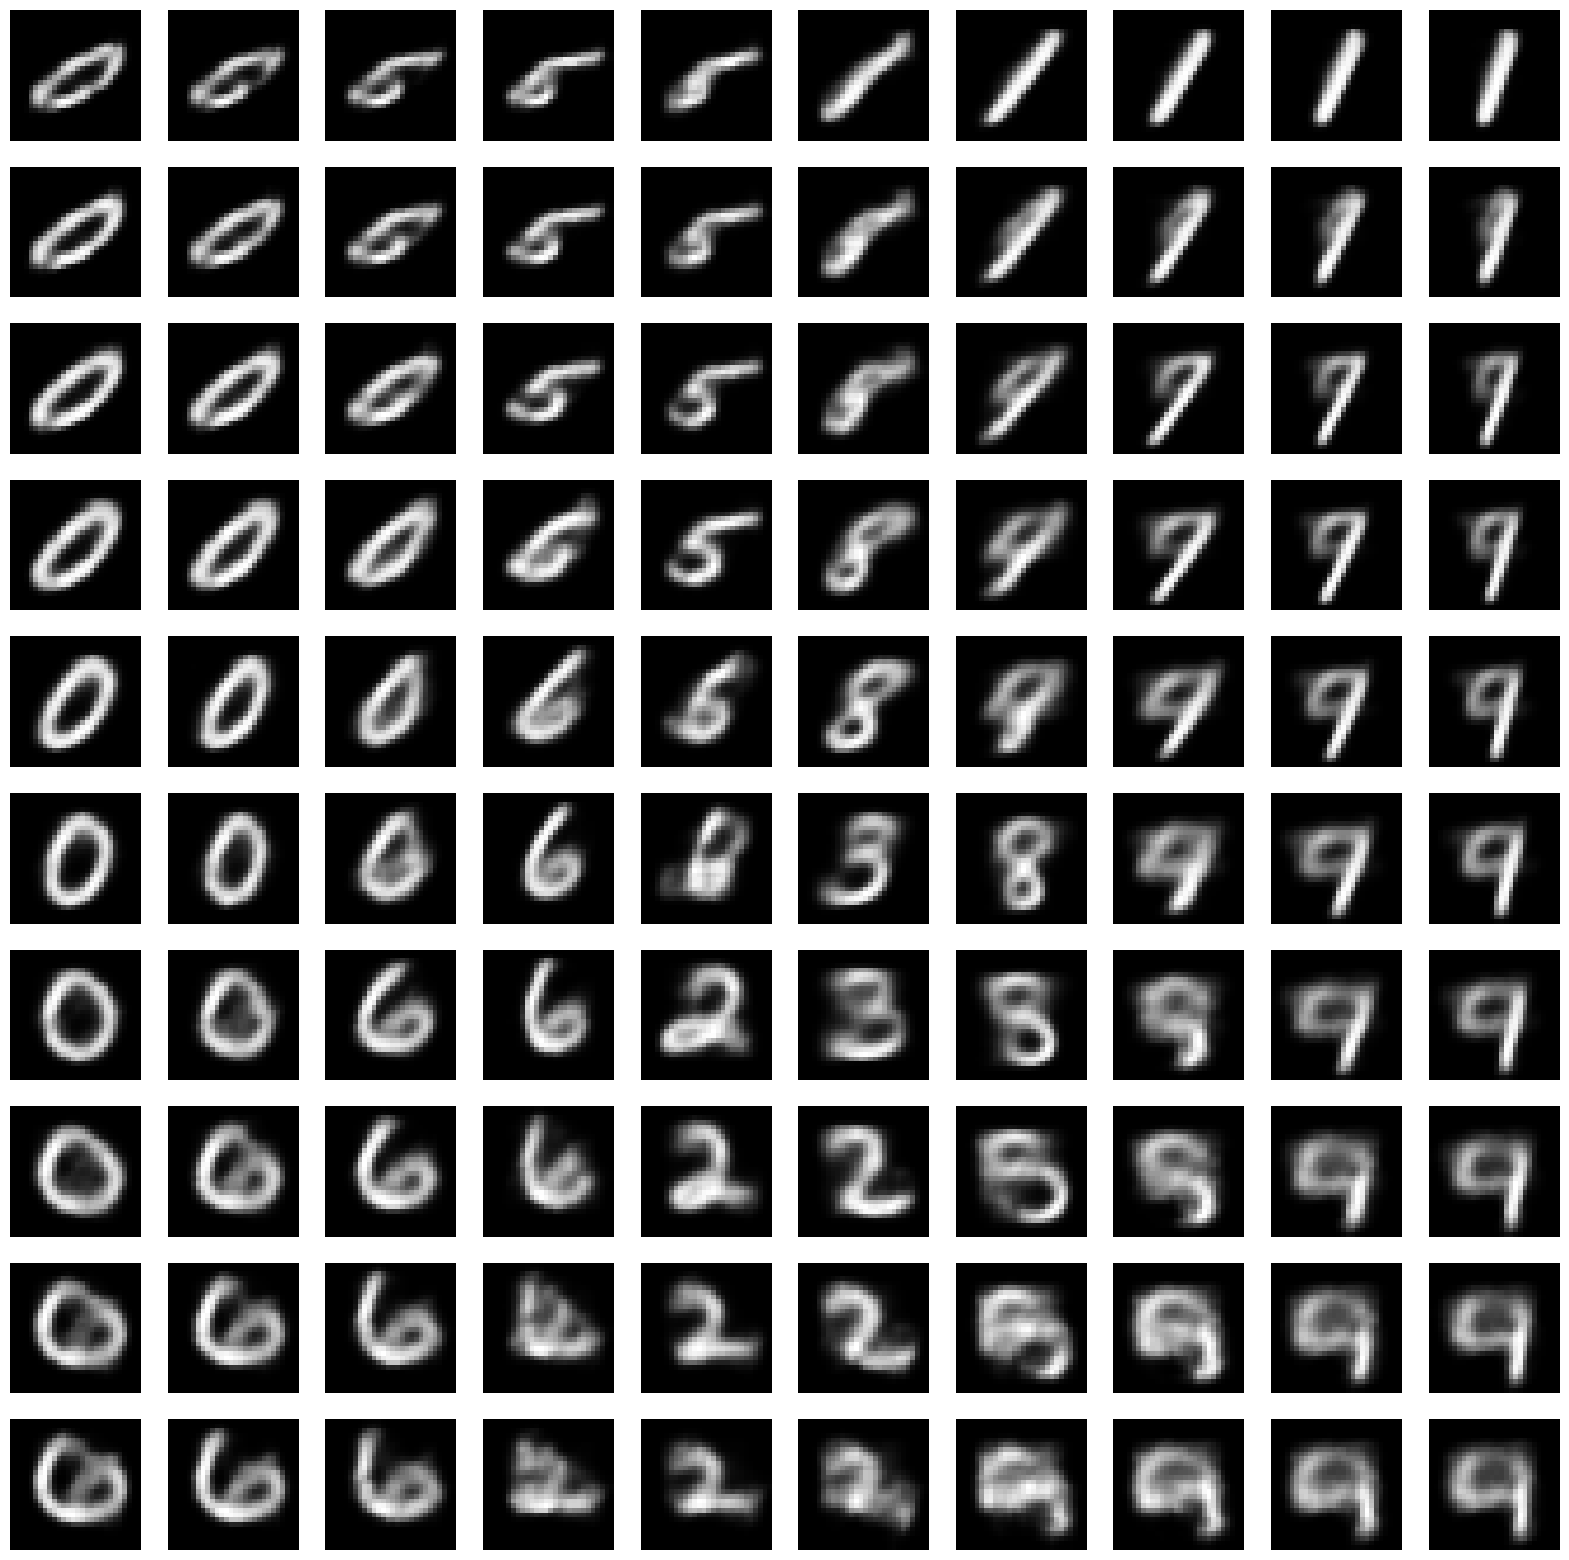

Epoch 10: Reconstruction Loss: 0.1860, Adversarial Loss (Encoder): 5.5223, Adversarial Loss (Discriminator): 0.0211


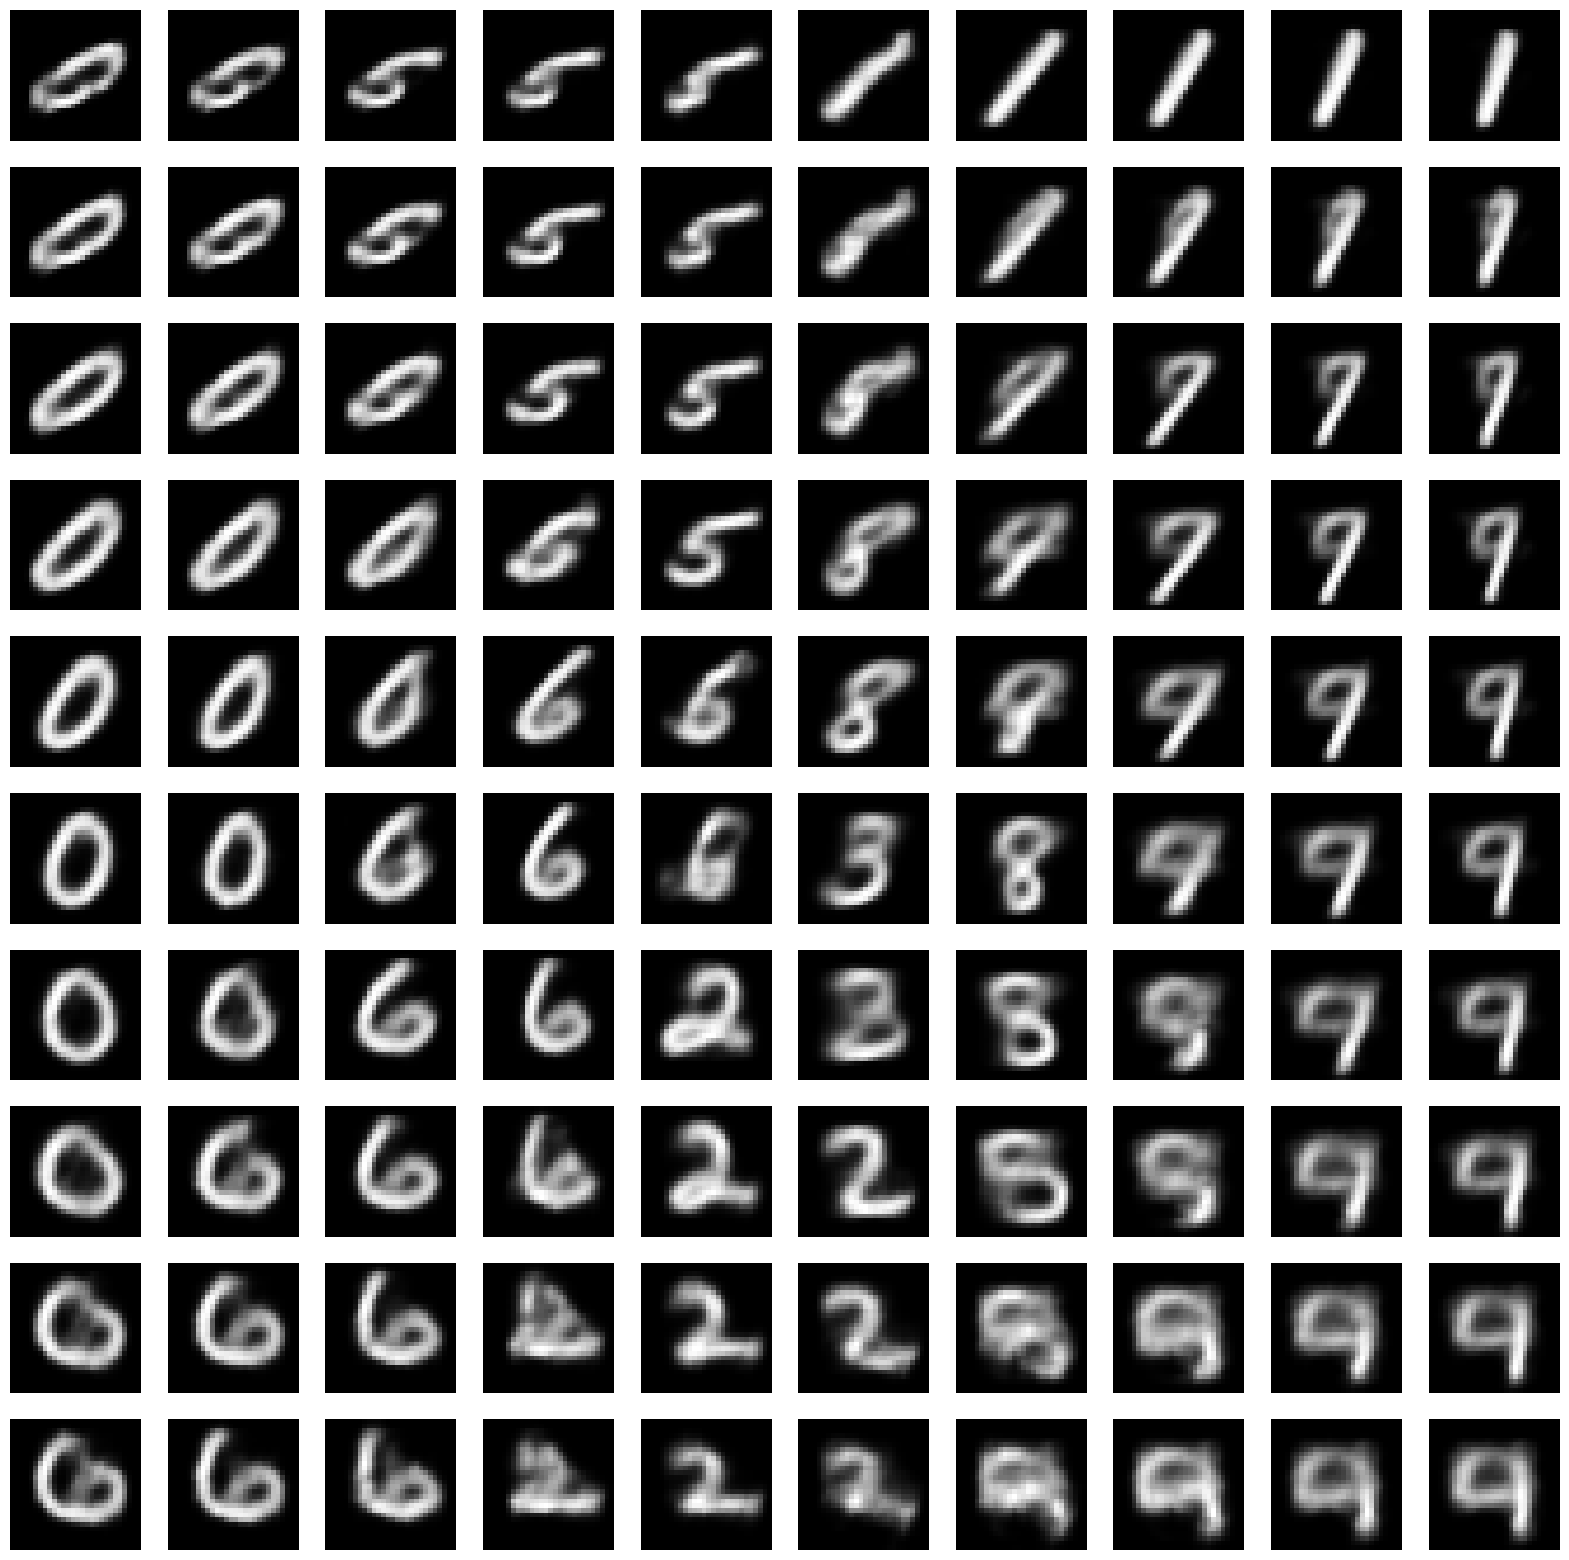

In [59]:
# Initialize models
model_enc_ae = build_model_enc().to(device)       # Encoder for Autoencoder
model_dec_ae = build_model_dec().to(device)       # Decoder for Autoencoder

model_enc_disc = build_model_enc().to(device)     # Encoder for Discriminator
model_disc = build_model_disc().to(device)        # Discriminator

# Define Autoencoder and Encoder-Decoder Discriminator as separate
model_ae = nn.Sequential(model_enc_ae, model_dec_ae).to(device)

# Define separate optimizers
optimizer_ae = optim.Adam(model_ae.parameters(), lr=1e-3)
optimizer_disc = optim.Adam(model_disc.parameters(), lr=1e-3)
optimizer_enc_disc = optim.Adam(model_enc_disc.parameters(), lr=1e-3)

# Train the Adversarial Autoencoder (AAE)
batchsize = 50
num_epochs_aae = 10  # Set to 10-20 or higher as needed

def set_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad = requires_grad

# Prepare DataLoader for AAE
train_loader_aae = DataLoader(train_dataset_mnist, batch_size=batchsize, shuffle=True)

for epochnumber in range(num_epochs_aae):
    for batch in train_loader_aae:
        batch = batch[0].float().to(device)
        
        # --------------------
        # Train Autoencoder
        # --------------------
        set_requires_grad(model_disc, False)        # Freeze Discriminator
        set_requires_grad(model_enc_ae, True)       # Ensure Autoencoder Encoder is trainable
        set_requires_grad(model_dec_ae, True)       # Ensure Autoencoder Decoder is trainable
        set_requires_grad(model_enc_disc, False)     # Freeze Discriminator's Encoder
        
        optimizer_ae.zero_grad()
        outputs = model_ae(batch)
        loss_recon = nn.functional.binary_cross_entropy(outputs, batch, reduction='mean')
        loss_recon.backward()
        optimizer_ae.step()
        
        # --------------------
        # Train Discriminator
        # --------------------
        set_requires_grad(model_disc, True)         # Unfreeze Discriminator
        set_requires_grad(model_enc_disc, True)     # Ensure Discriminator's Encoder is trainable
        set_requires_grad(model_enc_ae, False)      # Freeze Autoencoder's Encoder
        
        optimizer_disc.zero_grad()
        
        # Real samples from Discriminator's Encoder
        encoded_real = model_enc_disc(batch)  # Shape: [batch_size, 2]
        labels_real = torch.zeros(encoded_real.size(0), 1).to(device)  # Label 0 for real (encoder)
        
        # Fake samples from prior (e.g., standard normal)
        encoded_fake = torch.randn(encoded_real.size(0), 2).to(device)  # Label 1 for fake (prior)
        labels_fake = torch.ones(encoded_fake.size(0), 1).to(device)
        
        # Discriminator input and labels
        disc_input = torch.cat([encoded_real, encoded_fake], dim=0)  # Shape: [2 * batch_size, 2]
        disc_labels = torch.cat([labels_real, labels_fake], dim=0)  # Shape: [2 * batch_size, 1]
        
        # Discriminator output
        disc_output = model_disc(disc_input)  # Shape: [2 * batch_size, 1]
        
        # Compute loss
        loss_disc = nn.functional.binary_cross_entropy(disc_output, disc_labels)
        loss_disc.backward()
        optimizer_disc.step()
        
        # --------------------
        # Train Encoder via Discriminator
        # --------------------
        set_requires_grad(model_disc, False)        # Freeze Discriminator
        set_requires_grad(model_enc_disc, True)     # Ensure Discriminator's Encoder is trainable
        set_requires_grad(model_enc_ae, True)       # Unfreeze Autoencoder's Encoder
        
        optimizer_enc_disc.zero_grad()
        
        # Encoder tries to fool the Discriminator
        encoded_real_enc_disc = model_enc_disc(batch)  # Shape: [batch_size, 2]
        labels_enc = torch.ones(encoded_real_enc_disc.size(0), 1).to(device)  # Want discriminator to label encoder's output as real
        
        # Discriminator output for encoder's encoded data
        disc_output_enc = model_disc(encoded_real_enc_disc)  # Shape: [batch_size, 1]
        
        # Compute loss
        loss_enc = nn.functional.binary_cross_entropy(disc_output_enc, labels_enc)
        loss_enc.backward()
        optimizer_enc_disc.step()
    
    # Print epoch losses
    print(f"Epoch {epochnumber + 1}: Reconstruction Loss: {loss_recon.item():.4f}, Adversarial Loss (Encoder): {loss_enc.item():.4f}, Adversarial Loss (Discriminator): {loss_disc.item():.4f}")
    
    # Generate and save images
    imagegrid(model_dec_ae, epochnumber + 1)